#Library Import

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
import gdown
import zipfile
#from google.colab import drive
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import keras
from tensorflow.keras.utils import image_dataset_from_directory
from keras.layers import Dense, Dropout, Flatten, RandomTranslation, RandomZoom, BatchNormalization, Activation, GlobalAveragePooling2D
import random

#drive.mount('/content/drive')

* Num of Data function

In [ ]:
def count_image_files_in_directory(directory_path):
    # Define a set of image file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

    try:
        # Check if the provided path exists and is a directory
        if not os.path.exists(directory_path):
            print(f"The path {directory_path} does not exist.")
            return
        if not os.path.isdir(directory_path):
            print(f"The path {directory_path} is not a directory.")
            return

        # Get the list of files in the directory
        files = os.listdir(directory_path)
        # Filter the files to include only images
        image_files = [file for file in files if os.path.splitext(file)[1].lower() in image_extensions]
        # Count the number of image files
        image_file_count = len(image_files)

        print(f"The number of image files in the directory '{directory_path.split('/')[-2] + '/' + directory_path.split('/')[-1]}' is: {image_file_count}")
    except Exception as e:
        print(f"An error occurred: {e}")

# classify Repair, Replace

## Original Data Download

* 상대적으로 부족한 Replace 데이터를 증강기술을 통해 개수를 늘려서 불균형을 해결함.
* jupyter notebook에서 증강 작업을 수행했고, 로컬에 저장해서 drive에 올림.
* 증강은 RandomRotation 40도, 수직,수평 20% 이내에서 이동, RandomZoom 20%, RandomFlip('horizontal')

In [ ]:
file_id = '1EHhBNMD7WhIIAlmmUatxaa8PAo6CYv2t'
output = 'original_repair_replace.zip'

if not os.path.isdir('original_repair_replace'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('original_repair_replace')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1EHhBNMD7WhIIAlmmUatxaa8PAo6CYv2t
From (redirected): https://drive.google.com/uc?id=1EHhBNMD7WhIIAlmmUatxaa8PAo6CYv2t&confirm=t&uuid=6a480faa-4a96-439b-842c-5e258382eb53
To: /content/original_repair_replace.zip
100%|██████████| 331M/331M [00:07<00:00, 45.4MB/s]


'original_repair_replace.zip' 파일이 정상적으로 다운로드되었습니다.
'original_repair_replace.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data
* 불균형이 어느정도 완화된 결과를 볼 수 있음. -> 이 데이터로 학습

In [ ]:
# # Specify the directory path
# train_repair_path = "./original_repair_replace/train/repair"
# train_replace_path = "./original_repair_replace/train/replace"
# test_repair_path = "./original_repair_replace/test/repair"
# test_replace_path = "./original_repair_replace/test/replace"
# validation_repair_path = "./original_repair_replace/validation/repair"
# validation_replace_path = "./original_repair_replace/validation/replace"

# # Call the function
# count_image_files_in_directory(train_repair_path)
# count_image_files_in_directory(train_replace_path)
# count_image_files_in_directory(test_repair_path)
# count_image_files_in_directory(test_replace_path)
# count_image_files_in_directory(validation_repair_path)
# count_image_files_in_directory(validation_replace_path)

### Create Dataset

In [ ]:
base_dir = pathlib.Path("./original_repair_replace")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

Found 1821 files belonging to 2 classes.
Found 168 files belonging to 2 classes.
Found 165 files belonging to 2 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'repair', 1: 'replace'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### VGG16

#### Data PreProcessing for VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = vgg_preprocess(images)
    return images, labels

# 전처리 함수 적용
vgg_train_dataset = train_dataset.map(preprocess_images)
vgg_validation_dataset = validation_dataset.map(preprocess_images)
vgg_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 95.2%, loss 5.33)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = keras.applications.vgg16.VGG16(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_repair_replace_vgg_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    vgg_train_dataset,
    epochs=80,
    validation_data=vgg_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.7849 - loss: 76.6702 - val_accuracy: 0.8750 - val_loss: 35.4432
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8930 - loss: 21.4826 - val_accuracy: 0.8869 - val_loss: 57.9319
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9399 - loss: 11.2123 - val_accuracy: 0.9048 - val_loss: 33.0434
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9426 - loss: 11.2529 - val_accuracy: 0.8929 - val_loss: 41.0350
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9377 - loss: 14.1626 - val_accuracy: 0.8750 - val_loss: 31.1870
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9551 - loss: 6.5599 - val_accuracy: 0.8988 - val_loss: 33.4211
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9450 - loss: 9.0845 - val_accuracy: 0.9167 - val_loss: 30.7367
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9536 - loss: 7.6946 - val_accura

In [ ]:
best_model = keras.models.load_model('original_repair_replace_vgg_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(vgg_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.9601 - loss: 3.6638
test_loss: 3.4316420555114746
test_acc: 0.9575757384300232


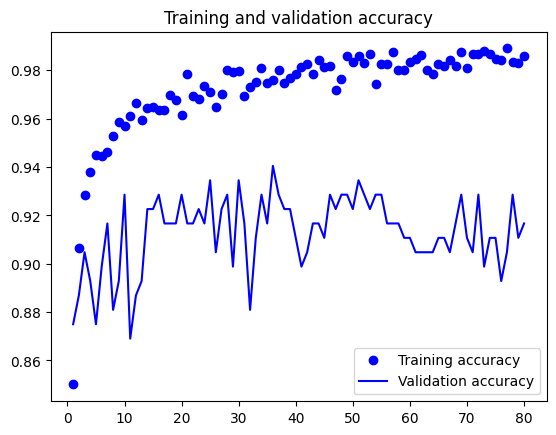

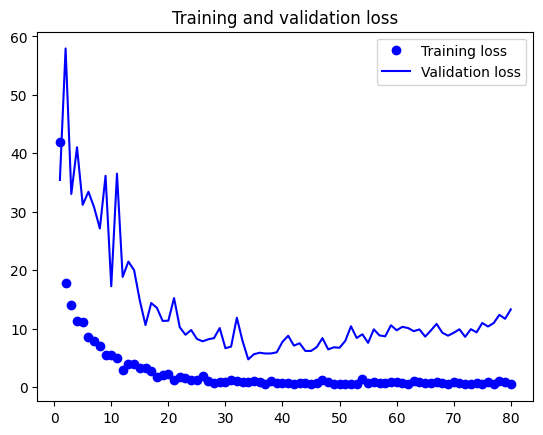

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### ResNet152

#### Data PreProcessing for ResNet152

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = resnet_preprocess(images)
    return images, labels

# 전처리 함수 적용
resnet_train_dataset = train_dataset.map(preprocess_images)
resnet_validation_dataset = validation_dataset.map(preprocess_images)
resnet_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 90%, loss 0.25)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = keras.applications.resnet.ResNet152(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape=input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_out, activation="sigmoid")(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_repair_replace_resnet_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]
history = model.fit(
    resnet_train_dataset,
    epochs=80,
    validation_data=resnet_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - accuracy: 0.7960 - loss: 0.4375 - val_accuracy: 0.8869 - val_loss: 0.2898
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.9241 - loss: 0.1976 - val_accuracy: 0.8988 - val_loss: 0.2806
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9385 - loss: 0.1603 - val_accuracy: 0.8929 - val_loss: 0.2725
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9535 - loss: 0.1326 - val_accuracy: 0.8869 - val_loss: 0.2659
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9479 - loss: 0.1295 - val_accuracy: 0.8988 - val_loss: 0.2595
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9626 - loss: 0.1242 - val_accuracy: 0.9048 - val_loss: 0.2541
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9669 - loss: 0.1065 - val_accuracy: 0.8929 - val_loss: 0.2626
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9652 - loss: 0.1002 - val_accura

In [ ]:
best_model = keras.models.load_model('original_repair_replace_resnet_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(resnet_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9638 - loss: 0.1161
test_loss: 0.13302810490131378
test_acc: 0.9575757384300232


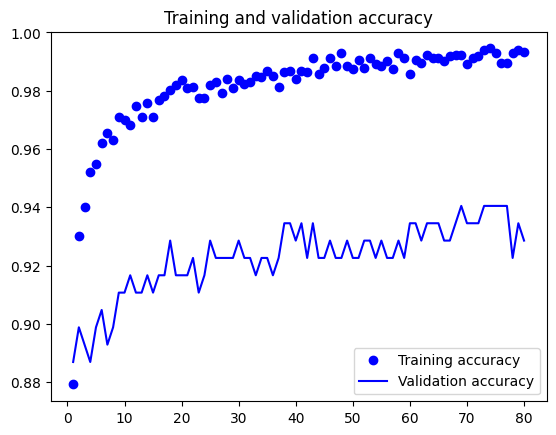

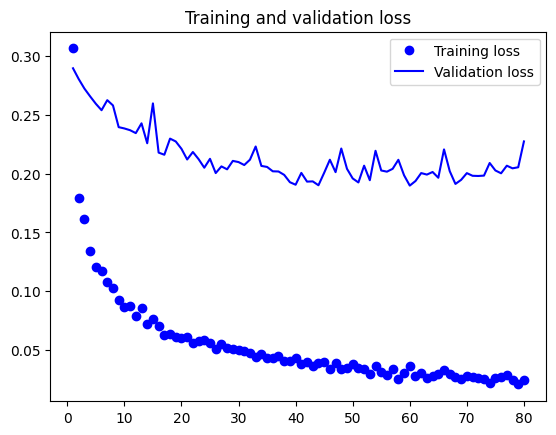

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 93.3%, loss 0.2)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_repair_replace_mobile_v1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-19-2590e925e4ee>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.6334 - loss: 0.6835 - val_accuracy: 0.8214 - val_loss: 0.3381
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.8848 - loss: 0.3045 - val_accuracy: 0.8810 - val_loss: 0.3204
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.9100 - loss: 0.2585 - val_accuracy: 0.8690 - val_loss: 0.3073
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.9145 - loss: 0.2212 - val_accuracy: 0.8631 - val_loss: 0.3047
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.9070 - loss: 0.2354 - val_accuracy: 0.8690 - val_loss: 0.3022
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.9278 - loss: 0.2032 - val_accuracy: 0.8929 - val_loss: 0.3025
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.9306 - loss: 0.1987 - val_accuracy: 0.8631 - val_loss: 0.3054
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms

In [ ]:
best_model = keras.models.load_model('original_repair_replace_mobile_v1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 88.5%, loss 0.88)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_repair_replace_mobile_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-29-44cb85d38fdf>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


Epoch 1/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.7373 - loss: 0.5257 - val_accuracy: 0.8750 - val_loss: 0.3886
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.8895 - loss: 0.3066 - val_accuracy: 0.8869 - val_loss: 0.3164
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9149 - loss: 0.2547 - val_accuracy: 0.8988 - val_loss: 0.2883
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.9091 - loss: 0.2554 - val_accuracy: 0.8988 - val_loss: 0.2811
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9153 - loss: 0.2294 - val_accuracy: 0.8988 - val_loss: 0.2730
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9212 - loss: 0.2263 - val_accuracy: 0.9048 - val_loss: 0.2721
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.9220 - loss: 0.2151 - val_accuracy: 0.9048 - val_loss: 0.2689
Epoch 8/80


KeyboardInterrupt: 

In [ ]:
best_model = keras.models.load_model('original_repair_replace_mobile_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3

#### Data PreProcessing for MobileNet v3

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 95.75%, loss 0.12)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_repair_replace_mobile_v3_large_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.7580 - loss: 0.5073 - val_accuracy: 0.8869 - val_loss: 0.2991
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 187ms/step - accuracy: 0.8933 - loss: 0.2917 - val_accuracy: 0.9167 - val_loss: 0.2769
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9077 - loss: 0.2613 - val_accuracy: 0.9107 - val_loss: 0.2710
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.9169 - loss: 0.2332 - val_accuracy: 0.9107 - val_loss: 0.2597
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.9201 - loss: 0.2260 - val_accuracy: 0.9048 - val_loss: 0.2461
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.9192 - loss: 0.2157 - val_accuracy: 0.9107 - val_loss: 0.2508
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.9190 - loss: 0.2255 - val_accuracy: 0.9167 - val_loss: 0.2403
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 191m

In [ ]:
best_model = keras.models.load_model("original_repair_replace_mobile_v3_large_augmentation_transfer.keras")
test_loss, test_acc = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.9537 - loss: 0.1273
test_loss: 0.11599565297365189
test_acc: 0.9515151381492615


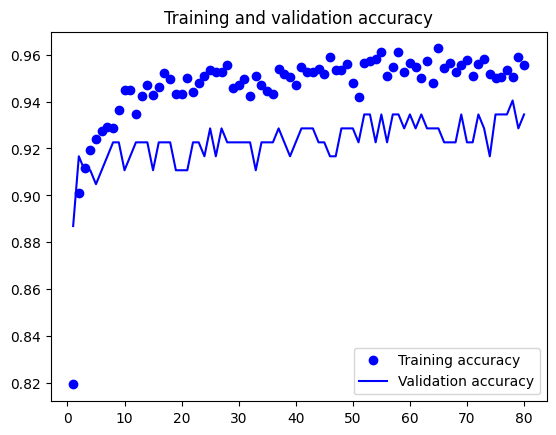

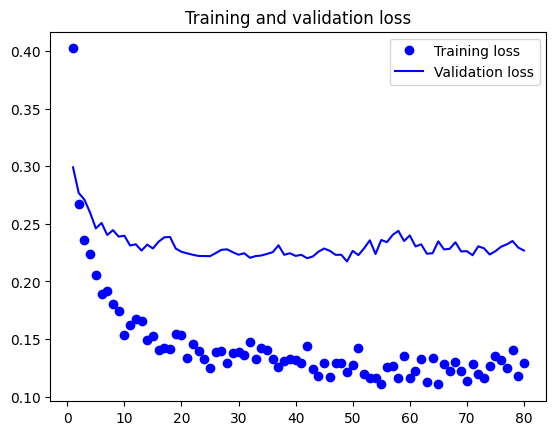

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## YOLO v2 Data Download
* YOLO v2 모델이 예측한 부분만을 crop하여 저장하였고, 데이터 증강을 통해 클래스 불균형을 해결하였습니다.
* 모델이 예측하지 못한 데이터는 원본 사진을 저장하여 사용하였습니다.

In [ ]:
file_id = '1PTCZ1KEJlAhiAhtVAX-T1M0Ctjl9Rg0o'
output = 'yolo_v2_repair_replace.zip'

if not os.path.isdir('yolo_v2_repair_replace'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('yolo_v2_repair_replace')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1PTCZ1KEJlAhiAhtVAX-T1M0Ctjl9Rg0o
From (redirected): https://drive.google.com/uc?id=1PTCZ1KEJlAhiAhtVAX-T1M0Ctjl9Rg0o&confirm=t&uuid=561bbcb5-94ed-4826-ab0f-2d3b51c172be
To: /content/yolo_v2_repair_replace.zip
100%|██████████| 87.2M/87.2M [00:01<00:00, 53.3MB/s]


'yolo_v2_repair_replace.zip' 파일이 정상적으로 다운로드되었습니다.
'yolo_v2_repair_replace.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data

In [ ]:
# train_repair_path = "./yolo_v2_repair_replace/train/repair"
# train_replace_path = "./yolo_v2_repair_replace/train/replace"
# test_repair_path = "./yolo_v2_repair_replace/test/repair"
# test_replace_path = "./yolo_v2_repair_replace/test/replace"
# validation_repair_path = "./yolo_v2_repair_replace/valid/repair"
# validation_replace_path = "./yolo_v2_repair_replace/valid/replace"

# # Call the function
# count_image_files_in_directory(train_repair_path)
# count_image_files_in_directory(train_replace_path)
# print('\n')
# count_image_files_in_directory(test_repair_path)
# count_image_files_in_directory(test_replace_path)
# print('\n')
# count_image_files_in_directory(validation_repair_path)
# count_image_files_in_directory(validation_replace_path)

### Create Dataset

In [ ]:
base_dir = pathlib.Path("./yolo_v2_repair_replace")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

Found 5848 files belonging to 2 classes.
Found 312 files belonging to 2 classes.
Found 157 files belonging to 2 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'repair', 1: 'replace'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### VGG16

#### Data PreProcessing for VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = vgg_preprocess(images)
    return images, labels

# 전처리 함수 적용
vgg_train_dataset = train_dataset.map(preprocess_images)
vgg_validation_dataset = validation_dataset.map(preprocess_images)
vgg_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 92.9%, loss 2.6)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = keras.applications.vgg16.VGG16(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_repair_replace_vgg_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    vgg_train_dataset,
    epochs=80,
    validation_data=vgg_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8437 - loss: 38.6210 - val_accuracy: 0.9327 - val_loss: 20.3480
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9153 - loss: 13.8969 - val_accuracy: 0.9199 - val_loss: 23.3274
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9265 - loss: 8.7417 - val_accuracy: 0.9359 - val_loss: 7.7914
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9313 - loss: 4.5256 - val_accuracy: 0.9359 - val_loss: 6.7804
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9363 - loss: 2.5675 - val_accuracy: 0.9199 - val_loss: 5.5964
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9420 - loss: 1.3491 - val_accuracy: 0.9263 - val_loss: 3.6640
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9432 - loss: 1.0326 - val_accuracy: 0.9327 - val_loss: 2.8300
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9376 - loss: 1.22

In [ ]:
best_model = keras.models.load_model('yolo_v2_repair_replace_vgg_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(vgg_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9289 - loss: 1.7718
test_loss: 2.0980119705200195
test_acc: 0.9235668778419495


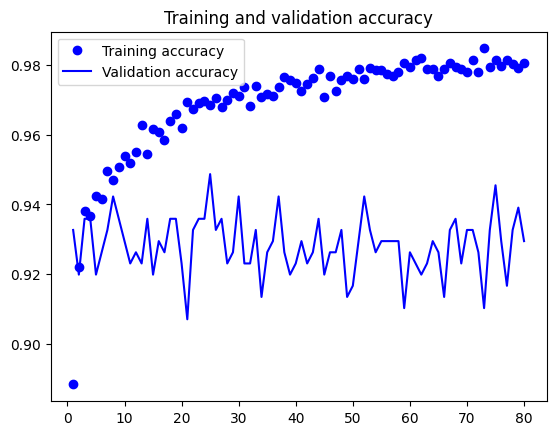

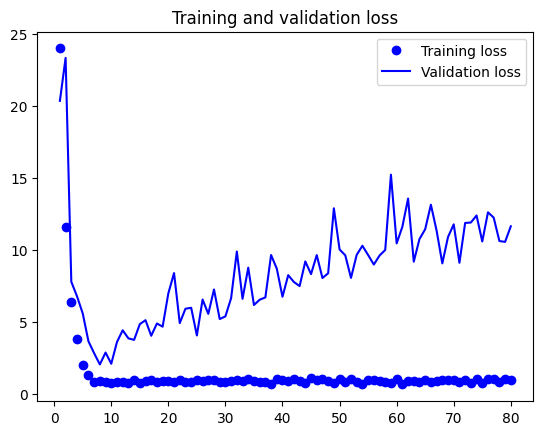

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### ResNet152

#### Data PreProcessing for ResNet152

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = resnet_preprocess(images)
    return images, labels

# 전처리 함수 적용
resnet_train_dataset = train_dataset.map(preprocess_images)
resnet_validation_dataset = validation_dataset.map(preprocess_images)
resnet_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 92.3%, loss 0.21)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = keras.applications.resnet.ResNet152(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape=input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_out, activation="sigmoid")(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_repair_replace_resnet_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]
history = model.fit(
    resnet_train_dataset,
    epochs=80,
    validation_data=resnet_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.8599 - loss: 0.3203 - val_accuracy: 0.9455 - val_loss: 0.1855
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.9460 - loss: 0.1523 - val_accuracy: 0.9487 - val_loss: 0.1783
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.9518 - loss: 0.1284 - val_accuracy: 0.9327 - val_loss: 0.1367
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.9641 - loss: 0.1062 - val_accuracy: 0.9487 - val_loss: 0.1358
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.9617 - loss: 0.1011 - val_accuracy: 0.9455 - val_loss: 0.1297
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9674 - loss: 0.0915 - val_accuracy: 0.9455 - val_loss: 0.1338
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9719 - loss: 0.0844 - val_accuracy: 0.9487 - val_loss: 0.1402
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9765 - loss: 0

In [ ]:
best_model = keras.models.load_model('yolo_v2_repair_replace_resnet_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(resnet_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9065 - loss: 0.2151
test_loss: 0.23455946147441864
test_acc: 0.9108280539512634


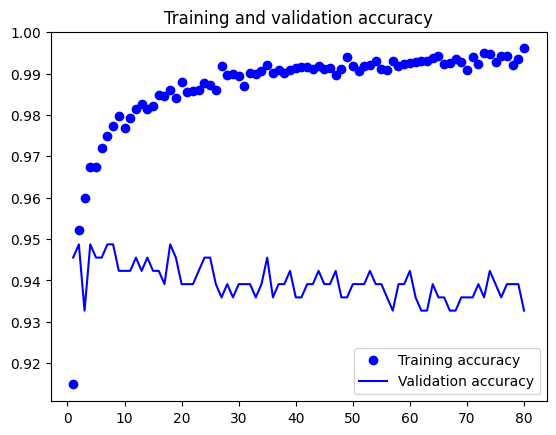

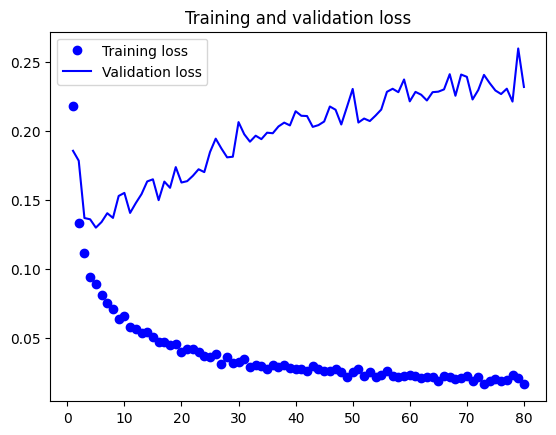

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 93%, loss 0.17)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_repair_replace_mobilev1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-7-897329fddb83>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.7775 - loss: 0.4661 - val_accuracy: 0.9199 - val_loss: 0.2218
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.8989 - loss: 0.2673 - val_accuracy: 0.9231 - val_loss: 0.2481
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9127 - loss: 0.2363 - val_accuracy: 0.9199 - val_loss: 0.2353
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.9130 - loss: 0.2230 - val_accuracy: 0.9327 - val_loss: 0.2138
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.9257 - loss: 0.2054 - val_accuracy: 0.9359 - val_loss: 0.1943
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9229 - loss: 0.2050 - val_accuracy: 0.9295 - val_loss: 0.2166
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9242 - loss: 0.1963 - val_accuracy: 0.9295 - val_loss: 0.2411
Epoch 8/80
183/183 ━━━━━━━━━━━━━

In [ ]:
best_model = keras.models.load_model('yolo_v2_repair_replace_mobilev1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9454 - loss: 0.1590
test_loss: 0.19126290082931519
test_acc: 0.9299362897872925


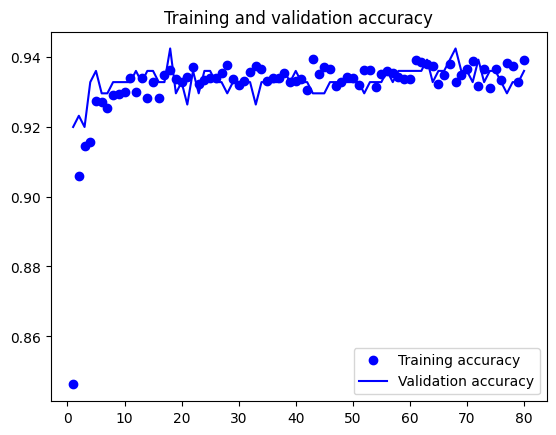

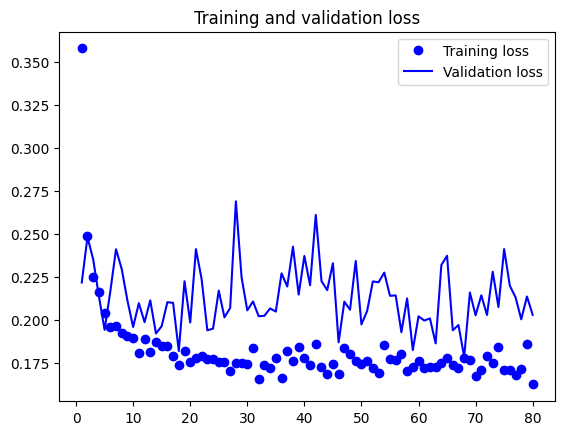

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 91.7%, loss 0.22)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_repair_replace_mobilev2_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-19-39bb6f960f19>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.8024 - loss: 0.4263 - val_accuracy: 0.9135 - val_loss: 0.2605
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9032 - loss: 0.2570 - val_accuracy: 0.9103 - val_loss: 0.2775
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9194 - loss: 0.2266 - val_accuracy: 0.9167 - val_loss: 0.2422
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.9148 - loss: 0.2290 - val_accuracy: 0.8846 - val_loss: 0.3195
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.9205 - loss: 0.2061 - val_accuracy: 0.9263 - val_loss: 0.2120
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.9199 - loss: 0.2100 - val_accuracy: 0.9263 - val_loss: 0.2244
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9267 - loss: 0.2023 - val_accuracy: 0.9231 - val_loss: 0.2195
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━

In [ ]:
best_model = keras.models.load_model('yolo_v2_repair_replace_mobilev2_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.9000 - loss: 0.2191
test_loss: 0.220994234085083
test_acc: 0.9108280539512634


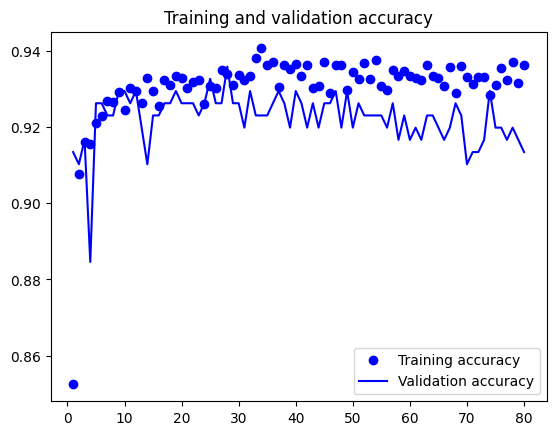

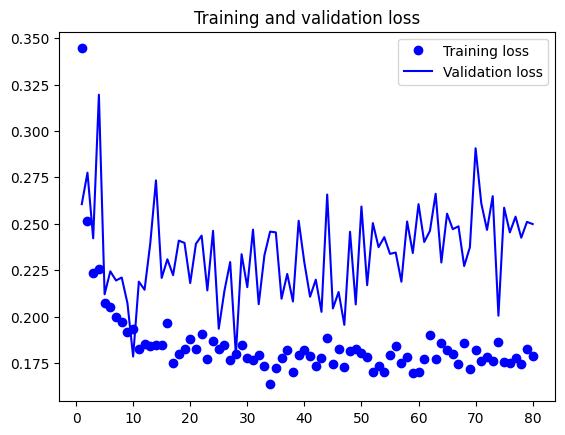

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3 Large

#### Data PreProcessing for MobileNet v3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 94.9%, loss 0.17)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_repair_replace_mobilev3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 33s 142ms/step - accuracy: 0.8148 - loss: 0.4146 - val_accuracy: 0.9199 - val_loss: 0.2293
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.9080 - loss: 0.2413 - val_accuracy: 0.9199 - val_loss: 0.2411
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.9262 - loss: 0.2041 - val_accuracy: 0.9391 - val_loss: 0.1869
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9309 - loss: 0.1992 - val_accuracy: 0.9359 - val_loss: 0.1798
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.9375 - loss: 0.1679 - val_accuracy: 0.9391 - val_loss: 0.1701
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9360 - loss: 0.1719 - val_accuracy: 0.9359 - val_loss: 0.1693
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.9415 - loss: 0.1690 - val_accuracy: 0.9359 - val_loss: 0.1688
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.9378 - loss: 0

In [ ]:
best_model = keras.models.load_model('yolo_v2_repair_replace_mobilev3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9549 - loss: 0.1655
test_loss: 0.19836148619651794
test_acc: 0.9363057613372803


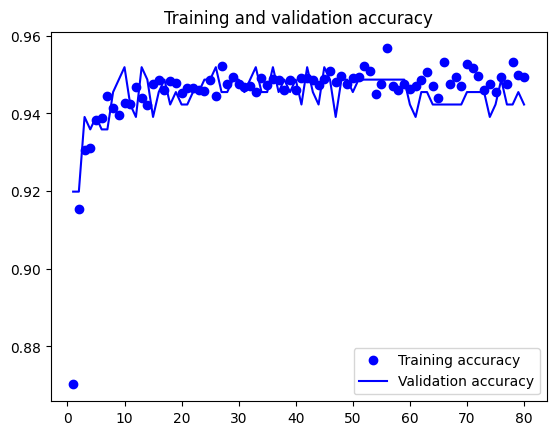

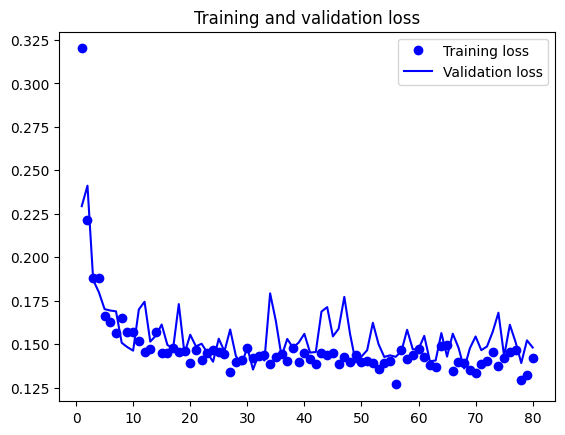

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Yolo v4 Data Download

In [ ]:
file_id = '1OAdqtsSbz9LCWbm2SHL7EK44Lsy7ZjZ-'
output = 'yolo_v4_repair_replace.zip'

if not os.path.isdir('yolo_v4_repair_replace'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('yolo_v4_repair_replace')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1OAdqtsSbz9LCWbm2SHL7EK44Lsy7ZjZ-
From (redirected): https://drive.google.com/uc?id=1OAdqtsSbz9LCWbm2SHL7EK44Lsy7ZjZ-&confirm=t&uuid=0c333f75-f3df-4c62-b8b0-26618c89236a
To: /content/yolo_v4_repair_replace.zip
100%|██████████| 95.5M/95.5M [00:02<00:00, 47.4MB/s]


'yolo_v4_repair_replace.zip' 파일이 정상적으로 다운로드되었습니다.
'yolo_v4_repair_replace.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data

In [ ]:
train_repair_path = "./yolo_v4_repair_replace/train/repair"
train_replace_path = "./yolo_v4_repair_replace/train/replace"
test_repair_path = "./yolo_v4_repair_replace/test/repair"
test_replace_path = "./yolo_v4_repair_replace/test/replace"
validation_repair_path = "./yolo_v4_repair_replace/valid/repair"
validation_replace_path = "./yolo_v4_repair_replace/valid/replace"

# Call the function
count_image_files_in_directory(train_repair_path)
count_image_files_in_directory(train_replace_path)
print('\n')
count_image_files_in_directory(test_repair_path)
count_image_files_in_directory(test_replace_path)
print('\n')
count_image_files_in_directory(validation_repair_path)
count_image_files_in_directory(validation_replace_path)

The number of image files in the directory 'train/repair' is: 2781
The number of image files in the directory 'train/replace' is: 2737


The number of image files in the directory 'test/repair' is: 132
The number of image files in the directory 'test/replace' is: 22


The number of image files in the directory 'valid/repair' is: 276
The number of image files in the directory 'valid/replace' is: 37


### Create Dataset

In [ ]:
base_dir = pathlib.Path("./yolo_v4_repair_replace")
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(360, 360),
    batch_size=32,
    class_names=['repair', 'replace']
    )

Found 5518 files belonging to 2 classes.
Found 313 files belonging to 2 classes.
Found 154 files belonging to 2 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'repair', 1: 'replace'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### VGG16

#### Data PreProcessing for VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = vgg_preprocess(images)
    return images, labels

# 전처리 함수 적용
vgg_train_dataset = train_dataset.map(preprocess_images)
vgg_validation_dataset = validation_dataset.map(preprocess_images)
vgg_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 90%, loss 4.25)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = keras.applications.vgg16.VGG16(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_repair_replace_vgg_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    vgg_train_dataset,
    epochs=80,
    validation_data=vgg_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.8367 - loss: 56.5990 - val_accuracy: 0.9265 - val_loss: 30.8908
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9214 - loss: 12.1053 - val_accuracy: 0.9329 - val_loss: 19.4907
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9300 - loss: 8.7479 - val_accuracy: 0.9265 - val_loss: 15.5391
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9398 - loss: 4.6612 - val_accuracy: 0.9297 - val_loss: 9.6824
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9423 - loss: 2.9771 - val_accuracy: 0.9329 - val_loss: 5.1777
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9376 - loss: 1.7437 - val_accuracy: 0.9393 - val_loss: 3.6843
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9472 - loss: 1.1569 - val_accuracy: 0.9329 - val_loss: 3.8332
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9445 - loss: 1.18

In [ ]:
best_model = keras.models.load_model('yolo_v4_repair_replace_vgg_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(vgg_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9293 - loss: 2.9375
test_loss: 4.3477044105529785
test_acc: 0.9090909361839294


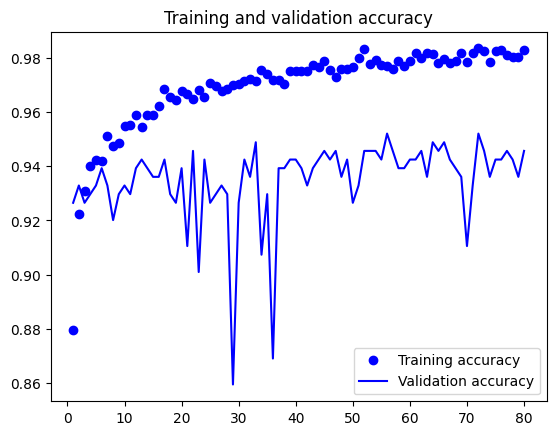

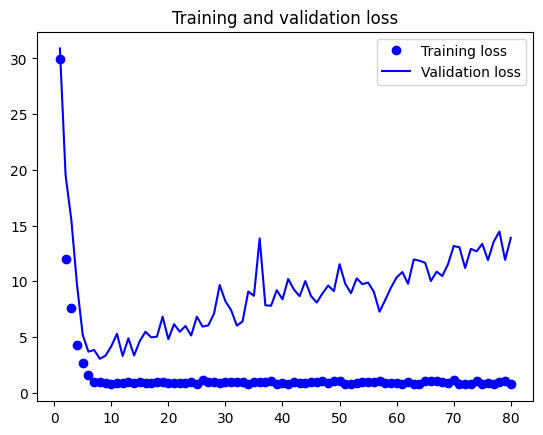

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### ResNet152

#### Data PreProcessing for ResNet152

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = resnet_preprocess(images)
    return images, labels

# 전처리 함수 적용
resnet_train_dataset = train_dataset.map(preprocess_images)
resnet_validation_dataset = validation_dataset.map(preprocess_images)
resnet_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 92.2%, loss 0.25)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = keras.applications.resnet.ResNet152(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape=input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_out, activation="sigmoid")(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_repair_replace_resnet_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]
history = model.fit(
    resnet_train_dataset,
    epochs=80,
    validation_data=resnet_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - accuracy: 0.8369 - loss: 0.3717 - val_accuracy: 0.9425 - val_loss: 0.1777
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.9460 - loss: 0.1543 - val_accuracy: 0.9425 - val_loss: 0.1438
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9571 - loss: 0.1208 - val_accuracy: 0.9457 - val_loss: 0.1487
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9548 - loss: 0.1111 - val_accuracy: 0.9361 - val_loss: 0.1552
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9666 - loss: 0.0918 - val_accuracy: 0.9393 - val_loss: 0.1623
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9747 - loss: 0.0825 - val_accuracy: 0.9393 - val_loss: 0.1570
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9714 - loss: 0.0753 - val_accuracy: 0.9425 - val_loss: 0.1577
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.9788 - loss: 0

In [ ]:
best_model = keras.models.load_model('yolo_v4_repair_replace_resnet_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(resnet_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9085 - loss: 0.2160
test_loss: 0.21604052186012268
test_acc: 0.9090909361839294


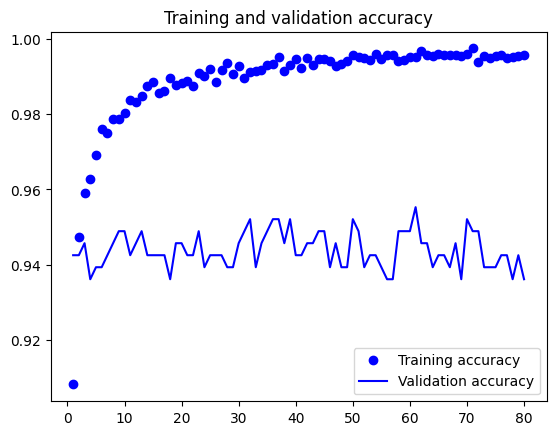

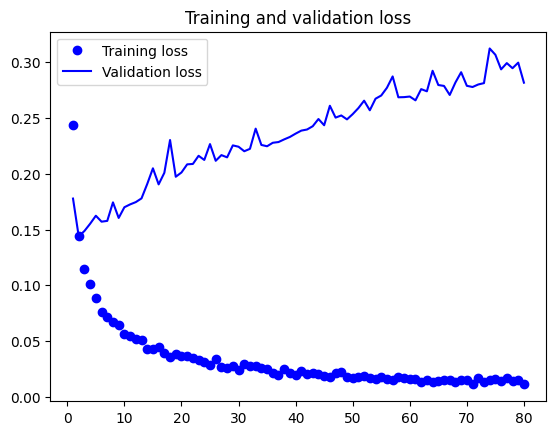

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 93.5%, loss 0.2)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_repair_replace_mobilev1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-7-cc820b58f68b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8026 - loss: 0.4341 - val_accuracy: 0.9265 - val_loss: 0.2574
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9052 - loss: 0.2497 - val_accuracy: 0.9297 - val_loss: 0.2083
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9164 - loss: 0.2233 - val_accuracy: 0.9297 - val_loss: 0.2316
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9226 - loss: 0.2050 - val_accuracy: 0.9265 - val_loss: 0.2450
Epoch 5/80
 11/173 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8997 - loss: 0.3017

KeyboardInterrupt: 

In [ ]:
best_model = keras.models.load_model('yolo_v4_repair_replace_mobilev1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 91.5%, loss 0.21)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_repair_replace_mobilev2_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

In [ ]:
best_model = keras.models.load_model('yolo_v4_repair_replace_mobilev2_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3 Large

#### Data PreProcessing for MobileNet v3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 93.5%, loss 0.25)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_repair_replace_mobilev3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

In [ ]:
best_model = keras.models.load_model('yolo_v4_repair_replace_mobilev3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Classify Crack, Complex, Others

## Original Data Download
* Crack: Crack류
* Complex: CombinationBreak + Etc
* Others: BullsEye + StarBreak + StoneChip

In [ ]:
file_id = '1uUCqrrx8bTWo7OQWM8QLx5o3GPMVthyf'
output = 'original_damagetype.zip'

if not os.path.isdir('original_damagetype'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('original_damagetype')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1uUCqrrx8bTWo7OQWM8QLx5o3GPMVthyf
From (redirected): https://drive.google.com/uc?id=1uUCqrrx8bTWo7OQWM8QLx5o3GPMVthyf&confirm=t&uuid=89e3f6df-baae-4744-958b-1663a57a6435
To: /content/original_damagetype.zip
100%|██████████| 290M/290M [00:03<00:00, 94.0MB/s]


'original_damagetype.zip' 파일이 정상적으로 다운로드되었습니다.
'original_damagetype.zip' 파일이 정상적으로 압축 해제되었습니다.


#### Num of Data

* Train data의 클래스 불균형 문제가 존재합니다. 따라서, Complex, Crack 데이터만 증강하여 Aug 폴더에 저장해두었습니다.
* 데이터는 train:test:validation = 7:2:1 로 split하였습니다.

In [ ]:
# Specify the directory path
train_complex_path = "./original_damagetype/train/Complex"
train_crack_path = "./original_damagetype/train/Crack"
train_others_path = "./original_damagetype/train/Others"

test_complex_path = "./original_damagetype/test/Complex"
test_crack_path = "./original_damagetype/test/Crack"
test_others_path = "./original_damagetype/test/Others"

validation_complex_path = "./original_damagetype/validation/Complex"
validation_crack_path = "./original_damagetype/validation/Crack"
validation_others_path = "./original_damagetype/validation/Others"


# Call the function
count_image_files_in_directory(train_complex_path)
count_image_files_in_directory(train_crack_path)
count_image_files_in_directory(train_others_path)
print('\n')
count_image_files_in_directory(test_complex_path)
count_image_files_in_directory(test_crack_path)
count_image_files_in_directory(test_others_path)
print('\n')
count_image_files_in_directory(validation_complex_path)
count_image_files_in_directory(validation_crack_path)
count_image_files_in_directory(validation_others_path)

The number of image files in the directory 'train/Complex' is: 431
The number of image files in the directory 'train/Crack' is: 434
The number of image files in the directory 'train/Others' is: 423


The number of image files in the directory 'test/Complex' is: 110
The number of image files in the directory 'test/Crack' is: 33
The number of image files in the directory 'test/Others' is: 121


The number of image files in the directory 'validation/Complex' is: 56
The number of image files in the directory 'validation/Crack' is: 18
The number of image files in the directory 'validation/Others' is: 61


In [ ]:
base_dir = pathlib.Path("./original_damagetype")

classes = ['Crack', 'Complex', 'Others']

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size = (360, 360),
    batch_size = 32,
    class_names = classes
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size = (360, 360),
    batch_size = 32,
    class_names=classes
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size = (360, 360),
    batch_size = 32,
    class_names = classes
    )

Found 1288 files belonging to 3 classes.
Found 135 files belonging to 3 classes.
Found 264 files belonging to 3 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'Crack', 1: 'Complex', 2: 'Others'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

#### VGG16

##### Data PreProcessing for VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = vgg_preprocess(images)
    return images, labels

# 전처리 함수 적용
vgg_train_dataset = train_dataset.map(preprocess_images)
vgg_validation_dataset = validation_dataset.map(preprocess_images)
vgg_test_dataset = test_dataset.map(preprocess_images)

##### Transfer Learning (Score: acc 62.1%, loss 6.86)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = keras.applications.vgg16.VGG16(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_damagetype_vgg_augemntation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    vgg_train_dataset,
    epochs=80,
    validation_data=vgg_validation_dataset,
    callbacks=callbacks)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.4239 - loss: 303.8120 - val_accuracy: 0.5778 - val_loss: 76.0489
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5639 - loss: 103.0912 - val_accuracy: 0.3259 - val_loss: 185.1955
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5574 - loss: 99.7392 - val_accuracy: 0.6148 - val_loss: 91.3306
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6488 - loss: 61.3259 - val_accuracy: 0.4667 - val_loss: 143.6091
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6230 - loss: 53.9248 - val_accuracy: 0.6222 - val_loss: 61.2170
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6589 - loss: 46.0338 - val_accuracy: 0.6222 - val_loss: 53.0207
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.7016 - loss: 31.0909 - val_accuracy: 0.6148 - val_loss: 47.4260
Epoch 8/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
best_model = keras.models.load_model('original_damagetype_vgg_augemntation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(vgg_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6397 - loss: 5.4545
test_loss: 6.0442118644714355
test_acc: 0.6212121248245239


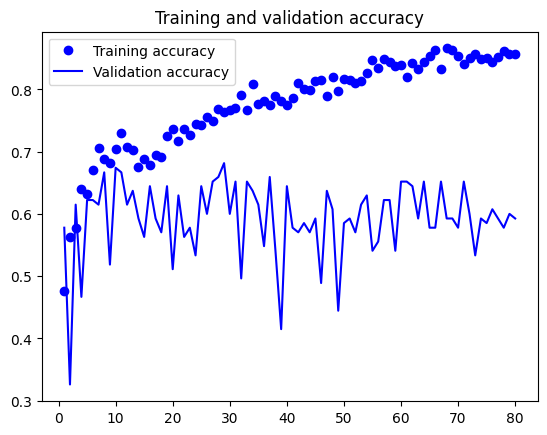

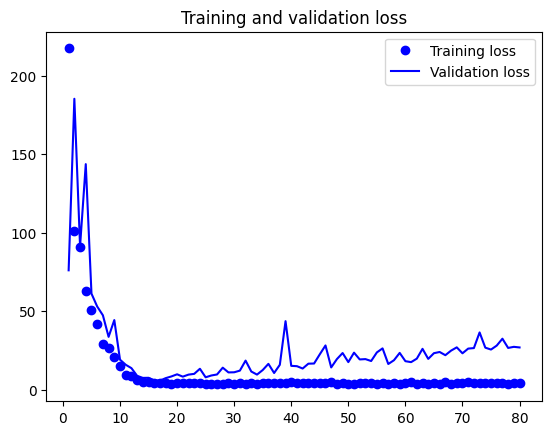

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 65.5%, loss 0.72)

In [ ]:
import tensorflow
def build_model(input_shape, num_out):
  conv_base = tensorflow.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = conv_base(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

model = build_model((360,360,3), 3)

model.compile(optimizer = 'Rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_damagetype_mobile_v1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-14-59de9e2ae78d>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tensorflow.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.4125 - loss: 1.3964 - val_accuracy: 0.4963 - val_loss: 1.0041
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5292 - loss: 1.0439 - val_accuracy: 0.5852 - val_loss: 0.8847
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5825 - loss: 0.9557 - val_accuracy: 0.6370 - val_loss: 0.8334
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6184 - loss: 0.8911 - val_accuracy: 0.6296 - val_loss: 0.8573
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6312 - loss: 0.8300 - val_accuracy: 0.6074 - val_loss: 0.8186
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5994 - loss: 0.8863 - val_accuracy: 0.6074 - val_loss: 0.8959
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6225 - loss: 0.8502 - val_accuracy: 0.5630 - val_loss: 0.8796
Epoch 8/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accur

In [ ]:
best_model = keras.models.load_model('original_damagetype_mobile_v1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.6912 - loss: 0.7134
test_loss: 0.7476900219917297
test_acc: 0.6666666865348816


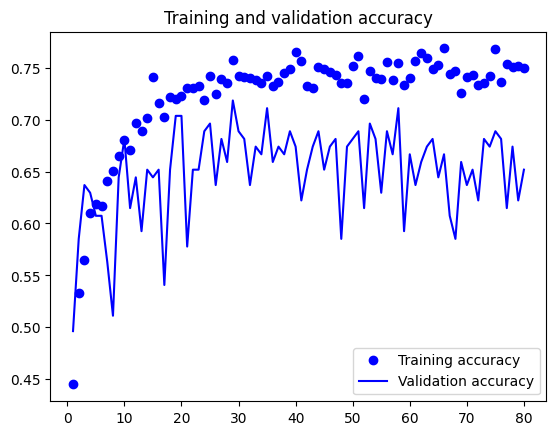

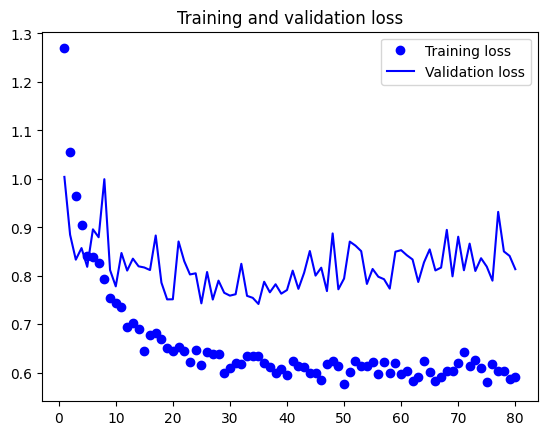

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 64.4%, loss 0.77)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_damagetype_mobile_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-18-42ac67b23b85>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.3992 - loss: 1.2933 - val_accuracy: 0.4667 - val_loss: 1.0243
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4701 - loss: 1.0869 - val_accuracy: 0.5407 - val_loss: 0.9211
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5317 - loss: 0.9820 - val_accuracy: 0.6519 - val_loss: 0.8483
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5256 - loss: 1.0148 - val_accuracy: 0.6667 - val_loss: 0.8351
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5946 - loss: 0.9275 - val_accuracy: 0.6815 - val_loss: 0.8268
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6198 - loss: 0.8551 - val_accuracy: 0.5852 - val_loss: 0.9271
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5964 - loss: 0.8742 - val_accuracy: 0.5630 - val_loss: 0.9212
Epoch 8/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy:

In [ ]:
best_model = keras.models.load_model('original_damagetype_mobile_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6304 - loss: 0.7711
test_loss: 0.7534735798835754
test_acc: 0.6515151262283325


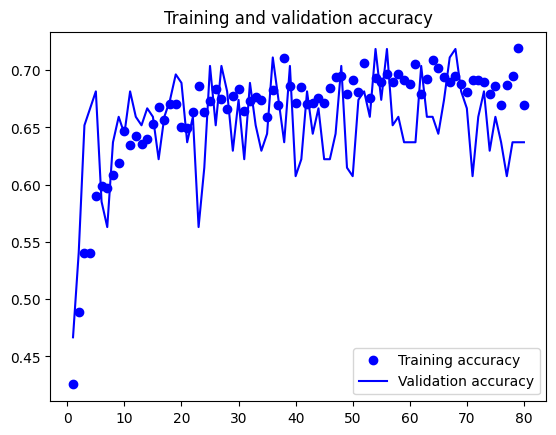

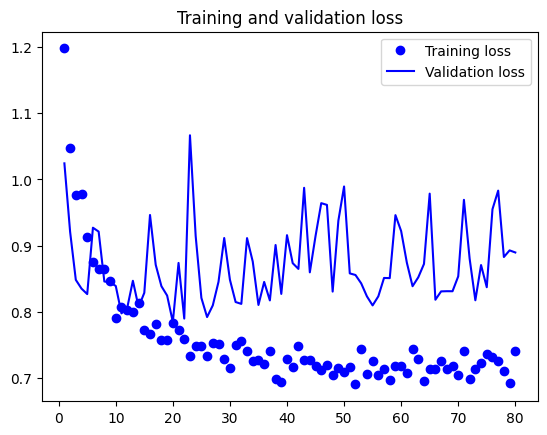

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3

#### Data PreProcessing for MobileNet v3

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 66.3%, loss 0.79)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_damagetype_mobile_v3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.3696 - loss: 1.5013 - val_accuracy: 0.5111 - val_loss: 1.0924
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5187 - loss: 1.1241 - val_accuracy: 0.5481 - val_loss: 0.9768
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5179 - loss: 1.0953 - val_accuracy: 0.6444 - val_loss: 0.8674
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5492 - loss: 1.0057 - val_accuracy: 0.6074 - val_loss: 0.9534
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5787 - loss: 0.9223 - val_accuracy: 0.6370 - val_loss: 0.8373
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6108 - loss: 0.8748 - val_accuracy: 0.6963 - val_loss: 0.8111
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6384 - loss: 0.8248 - val_accuracy: 0.6593 - val_loss: 0.8382
Epoch 8/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accurac

In [ ]:
best_model = keras.models.load_model('original_damagetype_mobile_v3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6344 - loss: 0.7745
test_loss: 0.7973276376724243
test_acc: 0.6287878751754761


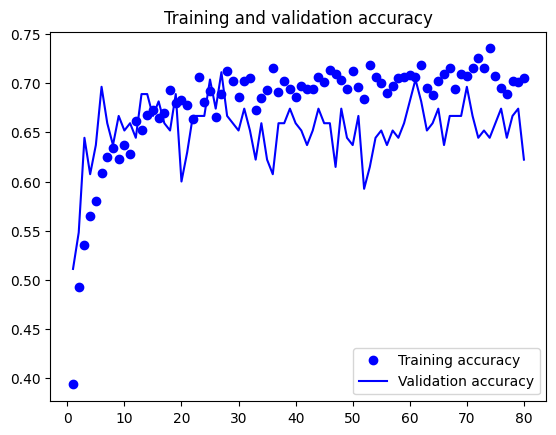

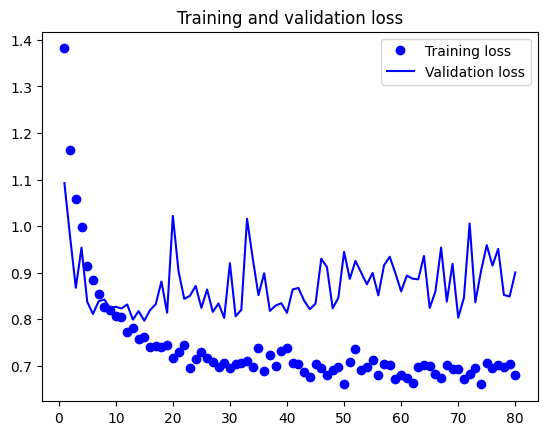

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### ResNet152

#### Data PreProcessing for ResNet152

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = resnet_preprocess(images)
    return images, labels

# 전처리 함수 적용
resnet_train_dataset = train_dataset.map(preprocess_images)
resnet_validation_dataset = validation_dataset.map(preprocess_images)
resnet_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 65.9%, loss 0.8)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = keras.applications.resnet.ResNet152(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape=input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_out, activation="softmax")(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 3)
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_damagetype_resnet_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    resnet_train_dataset,
    epochs=80,
    validation_data=resnet_validation_dataset,
    callbacks=callbacks)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - accuracy: 0.4311 - loss: 1.2396 - val_accuracy: 0.3926 - val_loss: 1.3151
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.5999 - loss: 0.8642 - val_accuracy: 0.5852 - val_loss: 0.9227
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.6146 - loss: 0.7889 - val_accuracy: 0.5852 - val_loss: 0.8770
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.6695 - loss: 0.7222 - val_accuracy: 0.5333 - val_loss: 0.9529
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.6791 - loss: 0.7034 - val_accuracy: 0.6593 - val_loss: 0.8730
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.7190 - loss: 0.6615 - val_accuracy: 0.6889 - val_loss: 0.8308
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7615 - loss: 0.6079 - val_accuracy: 0.6444 - val_loss: 0.9763
Epoch 8/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/ste

In [ ]:
best_model = keras.models.load_model('original_damagetype_resnet_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(resnet_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.6141 - loss: 0.9230
test_loss: 0.8291640877723694
test_acc: 0.6590909361839294


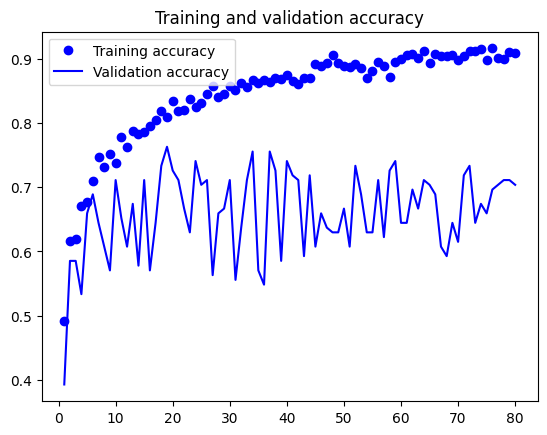

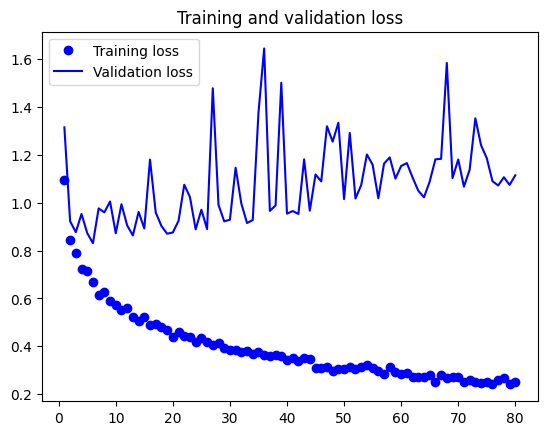

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Yolo v2 Data  Download

In [ ]:
file_id = '16vkNuZ6ez8BHDw5lHSh4zKOpbYLJeOjf'
output = 'yolo_v2_damagetype.zip'

if not os.path.isdir('yolo_v2_damagetype'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('yolo_v2_damagetype')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=16vkNuZ6ez8BHDw5lHSh4zKOpbYLJeOjf
From (redirected): https://drive.google.com/uc?id=16vkNuZ6ez8BHDw5lHSh4zKOpbYLJeOjf&confirm=t&uuid=423cb83d-b9a7-4529-9252-be74e3512c55
To: /content/yolo_v2_damagetype.zip
100%|██████████| 42.3M/42.3M [00:00<00:00, 104MB/s]


'yolo_v2_damagetype.zip' 파일이 정상적으로 다운로드되었습니다.
'yolo_v2_damagetype.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data

In [ ]:
# Specify the directory path
train_complex_path = "./yolo_v2_damagetype/train/Complex"
train_crack_path = "./yolo_v2_damagetype/train/Crack"
train_others_path = "./yolo_v2_damagetype/train/Others"

test_complex_path = "./yolo_v2_damagetype/test/Complex"
test_crack_path = "./yolo_v2_damagetype/test/Crack"
test_others_path = "./yolo_v2_damagetype/test/Others"

validation_complex_path = "./yolo_v2_damagetype/valid/Complex"
validation_crack_path = "./yolo_v2_damagetype/valid/Crack"
validation_others_path = "./yolo_v2_damagetype/valid/Others"


# Call the function
count_image_files_in_directory(train_complex_path)
count_image_files_in_directory(train_crack_path)
count_image_files_in_directory(train_others_path)
print('\n')
count_image_files_in_directory(test_complex_path)
count_image_files_in_directory(test_crack_path)
count_image_files_in_directory(test_others_path)
print('\n')
count_image_files_in_directory(validation_complex_path)
count_image_files_in_directory(validation_crack_path)
count_image_files_in_directory(validation_others_path)

The number of image files in the directory 'train/Complex' is: 1798
The number of image files in the directory 'train/Crack' is: 1868
The number of image files in the directory 'train/Others' is: 1854


The number of image files in the directory 'test/Complex' is: 57
The number of image files in the directory 'test/Crack' is: 17
The number of image files in the directory 'test/Others' is: 76


The number of image files in the directory 'valid/Complex' is: 129
The number of image files in the directory 'valid/Crack' is: 31
The number of image files in the directory 'valid/Others' is: 153


### Create Dataset

In [ ]:
base_dir = pathlib.Path("./yolo_v2_damagetype")

classes = ['Crack', 'Complex', 'Others']

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size = (360, 360),
    batch_size = 32,
    class_names = classes
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size = (360, 360),
    batch_size = 32,
    class_names=classes
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size = (360, 360),
    batch_size = 32,
    class_names = classes
    )

Found 5520 files belonging to 3 classes.
Found 313 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'Crack', 1: 'Complex', 2: 'Others'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### VGG16

#### Data PreProcessing for VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = vgg_preprocess(images)
    return images, labels

# 전처리 함수 적용
vgg_train_dataset = train_dataset.map(preprocess_images)
vgg_validation_dataset = validation_dataset.map(preprocess_images)
vgg_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 61.3%, loss 14.2)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = keras.applications.vgg16.VGG16(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_damagetype_vgg_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    vgg_train_dataset,
    epochs=80,
    validation_data=vgg_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.5130 - loss: 132.6660 - val_accuracy: 0.4569 - val_loss: 63.8814
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.6052 - loss: 33.6958 - val_accuracy: 0.6134 - val_loss: 20.0332
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5999 - loss: 8.2602 - val_accuracy: 0.4345 - val_loss: 6.6772
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5585 - loss: 3.6554 - val_accuracy: 0.5847 - val_loss: 3.6309
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.5777 - loss: 3.5789 - val_accuracy: 0.4984 - val_loss: 14.4962
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5995 - loss: 3.8157 - val_accuracy: 0.3419 - val_loss: 7.8756
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5963 - loss: 3.7050 - val_accuracy: 0.5879 - val_loss: 5.4791
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6126 - loss: 3.

In [ ]:
best_model = keras.models.load_model('yolo_v2_damagetype_vgg_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(vgg_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5118 - loss: 4.7081
test_loss: 4.6422038078308105
test_acc: 0.5066666603088379


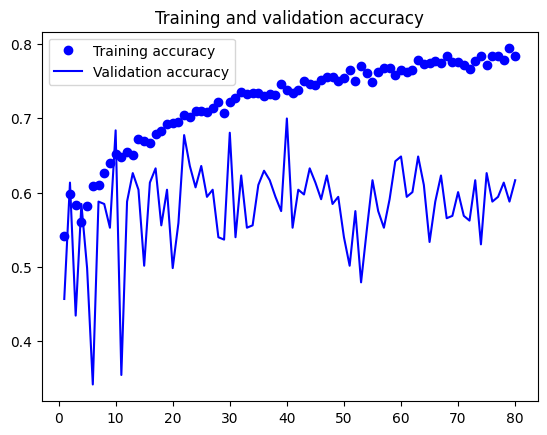

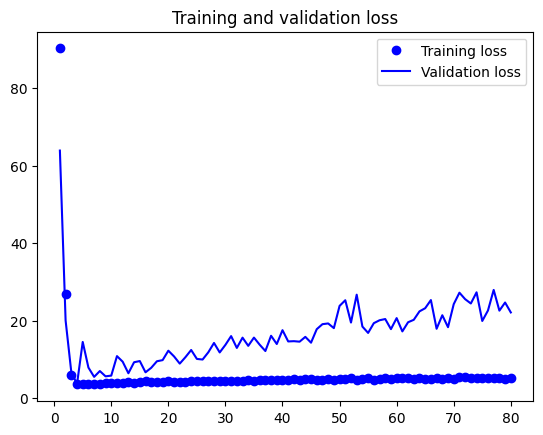

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### ResNet152

##### Data PreProcessing for ResNet152

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = resnet_preprocess(images)
    return images, labels

# 전처리 함수 적용
resnet_train_dataset = train_dataset.map(preprocess_images)
resnet_validation_dataset = validation_dataset.map(preprocess_images)
resnet_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 62.6%, loss 0.98)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = keras.applications.resnet.ResNet152(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape=input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_out, activation="softmax")(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 3)
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_damagetype_resnet_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    resnet_train_dataset,
    epochs=80,
    validation_data=resnet_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.5500 - loss: 0.9721 - val_accuracy: 0.6486 - val_loss: 0.8410
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.6969 - loss: 0.6944 - val_accuracy: 0.6102 - val_loss: 0.9401
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.7266 - loss: 0.6364 - val_accuracy: 0.5879 - val_loss: 1.0164
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.7536 - loss: 0.5951 - val_accuracy: 0.6709 - val_loss: 0.8482
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7674 - loss: 0.5598 - val_accuracy: 0.6486 - val_loss: 0.9086
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7779 - loss: 0.5427 - val_accuracy: 0.5495 - val_loss: 1.1523
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.7787 - loss: 0.5255 - val_accuracy: 0.6102 - val_loss: 1.0536
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7844 - loss: 0

In [ ]:
best_model = keras.models.load_model('yolo_v2_damagetype_resnet_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(resnet_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.4825 - loss: 1.1836
test_loss: 1.0625723600387573
test_acc: 0.5333333611488342


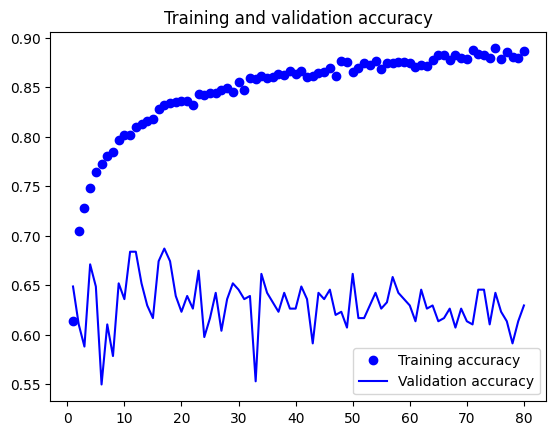

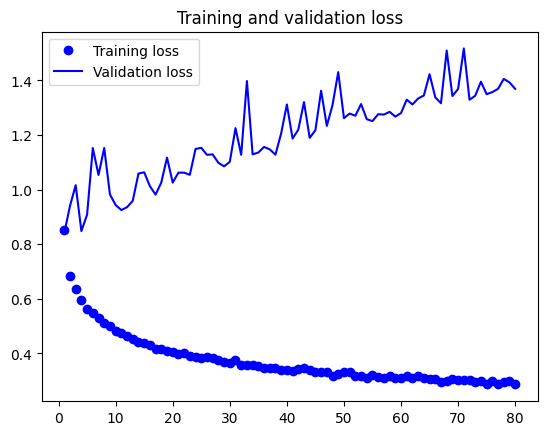

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v1

##### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 56%, loss 0.91)

In [ ]:
import tensorflow
def build_model(input_shape, num_out):
  conv_base = tensorflow.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = conv_base(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

model = build_model((360,360,3), 3)

model.compile(optimizer = 'Rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_damagetype_mobilev1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-43-37b372cc32af>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tensorflow.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.4526 - loss: 1.1854 - val_accuracy: 0.5399 - val_loss: 0.9424
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5897 - loss: 0.8985 - val_accuracy: 0.5367 - val_loss: 0.9437
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6314 - loss: 0.8192 - val_accuracy: 0.6102 - val_loss: 0.8735
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6632 - loss: 0.7843 - val_accuracy: 0.6422 - val_loss: 0.8345
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6597 - loss: 0.7685 - val_accuracy: 0.5751 - val_loss: 0.9229
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6607 - loss: 0.7611 - val_accuracy: 0.5911 - val_loss: 0.8898
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6786 - loss: 0.7429 - val_accuracy: 0.6134 - val_loss: 0.8436
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6792 - loss: 0.7318 - val_acc

In [ ]:
best_model = keras.models.load_model('yolo_v2_damagetype_mobilev1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 861ms/step - accuracy: 0.6014 - loss: 0.8836
test_loss: 0.9036980271339417
test_acc: 0.5933333039283752


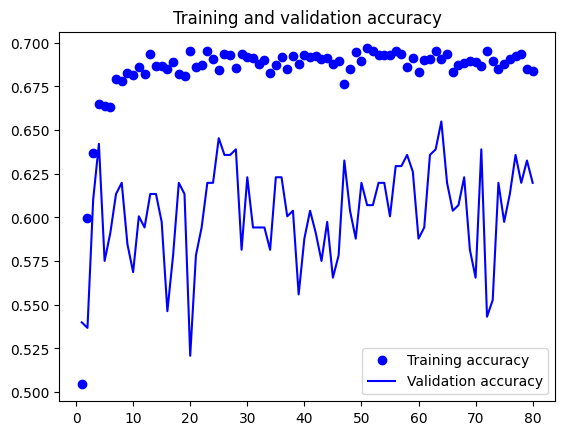

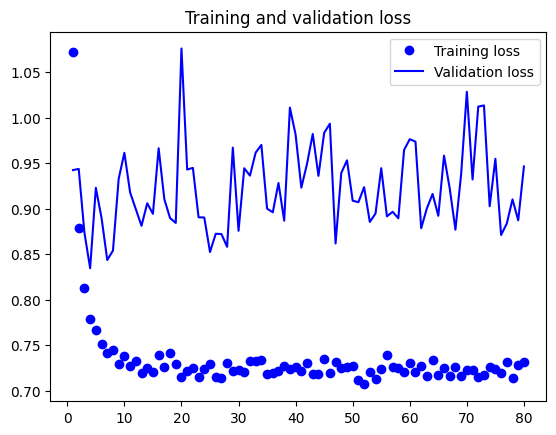

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

##### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 54.6%, loss 0.89)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_damagetype_mobilev2_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-47-d26817821ffe>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.4537 - loss: 1.1608 - val_accuracy: 0.5463 - val_loss: 0.9144
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5465 - loss: 0.9531 - val_accuracy: 0.5527 - val_loss: 0.8909
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6053 - loss: 0.8613 - val_accuracy: 0.6006 - val_loss: 0.8433
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6030 - loss: 0.8790 - val_accuracy: 0.6134 - val_loss: 0.8511
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6354 - loss: 0.8146 - val_accuracy: 0.5559 - val_loss: 0.9131
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6337 - loss: 0.8094 - val_accuracy: 0.6070 - val_loss: 0.8679
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6331 - loss: 0.8198 - val_accuracy: 0.5942 - val_loss: 0.8854
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6424 - loss: 0.8060 - val_acc

In [ ]:
best_model = keras.models.load_model('yolo_v2_damagetype_mobilev2_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5443 - loss: 0.8868
test_loss: 0.8985713720321655
test_acc: 0.5600000023841858


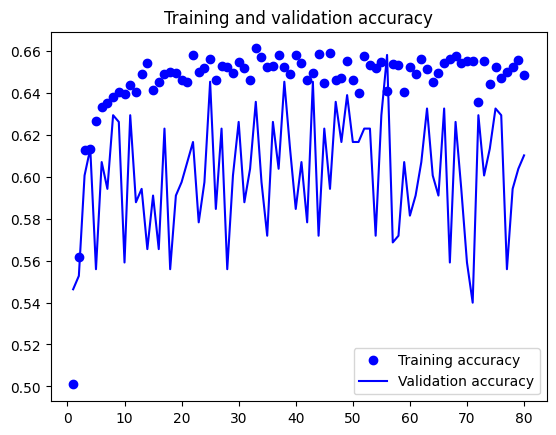

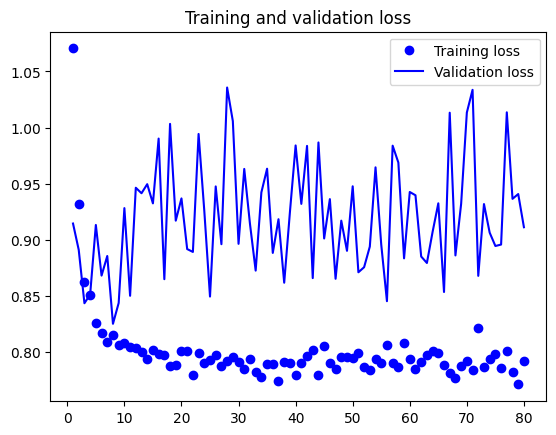

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3 Large

##### Data PreProcessing for MobileNet v3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 56%, loss 0.97)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_damagetype_mobilev3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.4630 - loss: 1.1503 - val_accuracy: 0.6134 - val_loss: 0.8547
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6139 - loss: 0.8733 - val_accuracy: 0.6454 - val_loss: 0.8405
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6432 - loss: 0.8066 - val_accuracy: 0.6518 - val_loss: 0.8207
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6566 - loss: 0.7809 - val_accuracy: 0.6550 - val_loss: 0.8064
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6729 - loss: 0.7668 - val_accuracy: 0.6645 - val_loss: 0.8017
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6792 - loss: 0.7604 - val_accuracy: 0.6198 - val_loss: 0.8450
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6781 - loss: 0.7467 - val_accuracy: 0.6166 - val_loss: 0.8292
Epoch 8/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6836 - loss: 0.7481 - val_acc

In [ ]:
best_model = keras.models.load_model('yolo_v2_damagetype_mobilev3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5556 - loss: 1.0446
test_loss: 1.0165488719940186
test_acc: 0.5600000023841858


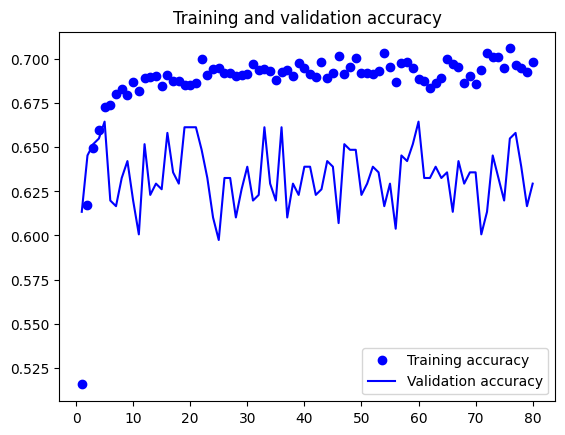

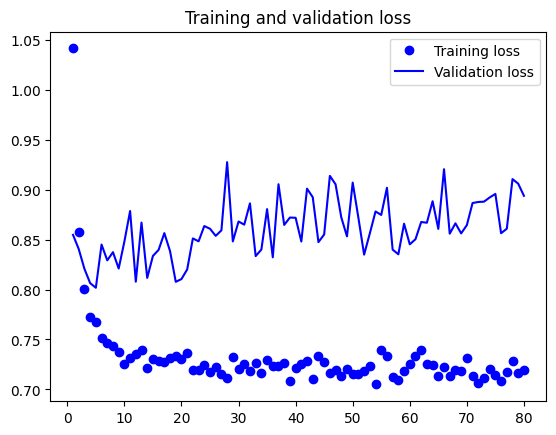

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Yolo v4 Data Download

In [ ]:
file_id = '1rtriFfsnErOONJPdDHlCtRzQLFI7wgoO'
output = 'yolo_v4_damagetype.zip'

if not os.path.isdir('yolo_v4_damagetype'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('yolo_v4_damagetype')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1rtriFfsnErOONJPdDHlCtRzQLFI7wgoO
From (redirected): https://drive.google.com/uc?id=1rtriFfsnErOONJPdDHlCtRzQLFI7wgoO&confirm=t&uuid=6828a0e8-b328-4b1a-94ba-2c05b64c4d31
To: /content/yolo_v4_damagetype.zip
100%|██████████| 74.1M/74.1M [00:00<00:00, 128MB/s]


'yolo_v4_damagetype.zip' 파일이 정상적으로 다운로드되었습니다.
'yolo_v4_damagetype.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data

In [ ]:
# Specify the directory path
train_complex_path = "./yolo_v4_damagetype/train/Complex"
train_crack_path = "./yolo_v4_damagetype/train/Crack"
train_others_path = "./yolo_v4_damagetype/train/Others"

test_complex_path = "./yolo_v4_damagetype/test/Complex"
test_crack_path = "./yolo_v4_damagetype/test/Crack"
test_others_path = "./yolo_v4_damagetype/test/Others"

valid_complex_path = "./yolo_v4_damagetype/valid/Complex"
valid_crack_path = "./yolo_v4_damagetype/valid/Crack"
valid_others_path = "./yolo_v4_damagetype/valid/Others"


# Call the function
count_image_files_in_directory(train_complex_path)
count_image_files_in_directory(train_crack_path)
count_image_files_in_directory(train_others_path)
print('\n')
count_image_files_in_directory(test_complex_path)
count_image_files_in_directory(test_crack_path)
count_image_files_in_directory(test_others_path)
print('\n')
count_image_files_in_directory(valid_complex_path)
count_image_files_in_directory(valid_crack_path)
count_image_files_in_directory(valid_others_path)

The number of image files in the directory 'train/Complex' is: 1398
The number of image files in the directory 'train/Crack' is: 1445
The number of image files in the directory 'train/Others' is: 1444


The number of image files in the directory 'test/Complex' is: 51
The number of image files in the directory 'test/Crack' is: 15
The number of image files in the directory 'test/Others' is: 69


The number of image files in the directory 'valid/Complex' is: 121
The number of image files in the directory 'valid/Crack' is: 29
The number of image files in the directory 'valid/Others' is: 139


### Create Dataset

In [ ]:
base_dir = pathlib.Path("./yolo_v4_damagetype")

classes = ['Crack', 'Complex', 'Others']

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size = (360, 360),
    batch_size = 32,
    class_names = classes
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size = (360, 360),
    batch_size = 32,
    class_names=classes
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size = (360, 360),
    batch_size = 32,
    class_names = classes
    )

Found 4287 files belonging to 3 classes.
Found 289 files belonging to 3 classes.
Found 135 files belonging to 3 classes.


### VGG16

#### Data PreProcessing for VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = vgg_preprocess(images)
    return images, labels

# 전처리 함수 적용
vgg_train_dataset = train_dataset.map(preprocess_images)
vgg_validation_dataset = validation_dataset.map(preprocess_images)
vgg_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 57%, loss 0.4)


In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = keras.applications.vgg16.VGG16(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_damagetype_vgg_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    vgg_train_dataset,
    epochs=80,
    validation_data=vgg_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.4758 - loss: 178.0453 - val_accuracy: 0.3702 - val_loss: 166.4298
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6029 - loss: 58.5820 - val_accuracy: 0.5571 - val_loss: 37.5263
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6551 - loss: 20.6605 - val_accuracy: 0.5709 - val_loss: 13.5172
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6225 - loss: 6.2022 - val_accuracy: 0.4464 - val_loss: 4.3525
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5756 - loss: 4.0810 - val_accuracy: 0.4325 - val_loss: 10.0834
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5972 - loss: 3.8175 - val_accuracy: 0.6228 - val_loss: 3.9249
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.6412 - loss: 3.6002 - val_accuracy: 0.4948 - val_loss: 4.9216
Epoch 8/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6335 - loss: 3.

In [ ]:
best_model = keras.models.load_model('yolo_v4_damagetype_vgg_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(vgg_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5672 - loss: 4.1804
test_loss: 3.682518720626831
test_acc: 0.6222222447395325


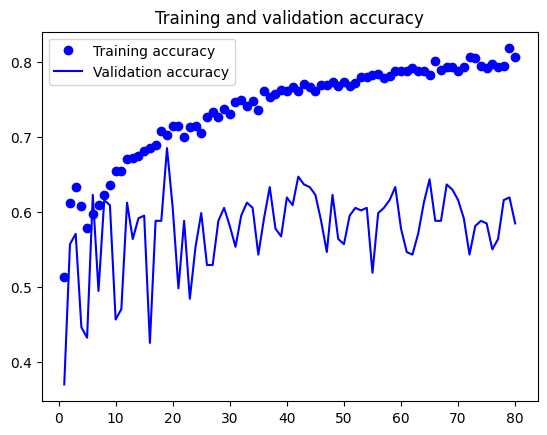

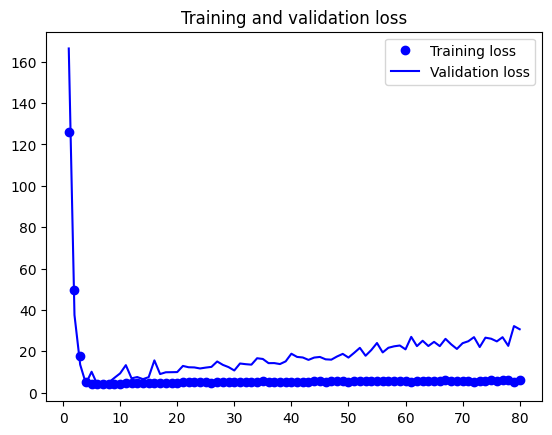

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### ResNet152

##### Data PreProcessing for ResNet152

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = resnet_preprocess(images)
    return images, labels

# 전처리 함수 적용
resnet_train_dataset = train_dataset.map(preprocess_images)
resnet_validation_dataset = validation_dataset.map(preprocess_images)
resnet_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 62.9%, loss 0.9)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = keras.applications.resnet.ResNet152(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape=input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Dense(num_out, activation="softmax")(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 3)
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_damagetype_resnet_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    resnet_train_dataset,
    epochs=80,
    validation_data=resnet_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.5375 - loss: 0.9860 - val_accuracy: 0.6194 - val_loss: 0.8660
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.6750 - loss: 0.7276 - val_accuracy: 0.6471 - val_loss: 0.8899
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7125 - loss: 0.6673 - val_accuracy: 0.5952 - val_loss: 0.9405
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7426 - loss: 0.6036 - val_accuracy: 0.6298 - val_loss: 0.9200
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7476 - loss: 0.5843 - val_accuracy: 0.6332 - val_loss: 1.0012
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7843 - loss: 0.5430 - val_accuracy: 0.5986 - val_loss: 1.0238
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7892 - loss: 0.5174 - val_accuracy: 0.5917 - val_loss: 1.0117
Epoch 8/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7784 - loss: 0

In [ ]:
best_model = keras.models.load_model('yolo_v4_damagetype_resnet_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(resnet_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6307 - loss: 0.8786 
test_loss: 0.9254559278488159
test_acc: 0.614814817905426


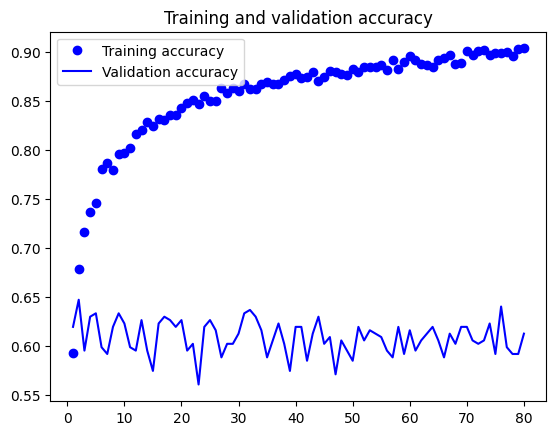

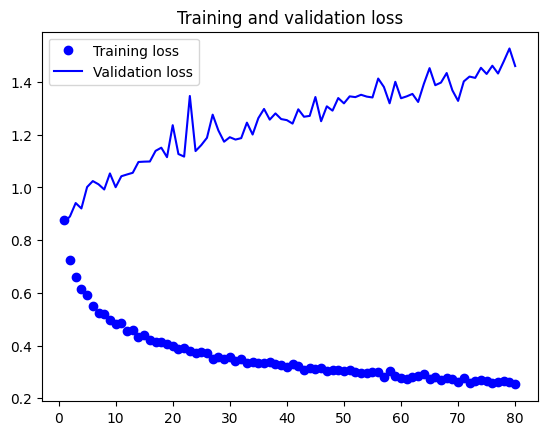

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v1

##### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 57.7%, loss 0.86)

In [ ]:
import tensorflow
def build_model(input_shape, num_out):
  conv_base = tensorflow.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = conv_base(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

model = build_model((360,360,3), 3)

model.compile(optimizer = 'Rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_damagetype_mobilev1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-12-ec9e8a604e68>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tensorflow.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.4179 - loss: 1.3162 - val_accuracy: 0.5848 - val_loss: 0.8718
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5533 - loss: 0.9795 - val_accuracy: 0.5917 - val_loss: 0.8737
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6178 - loss: 0.8632 - val_accuracy: 0.5952 - val_loss: 0.8787
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6492 - loss: 0.8039 - val_accuracy: 0.6228 - val_loss: 0.8292
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6606 - loss: 0.7765 - val_accuracy: 0.5882 - val_loss: 0.9022
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6659 - loss: 0.7530 - val_accuracy: 0.6090 - val_loss: 0.8265
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6711 - loss: 0.7598 - val_accuracy: 0.6159 - val_loss: 0.8320
Epoch 8/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6739 - loss: 0.7486 - val_acc

In [ ]:
best_model = keras.models.load_model('yolo_v4_damagetype_mobilev1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 676ms/step - accuracy: 0.6300 - loss: 0.8467
test_loss: 0.8475567102432251
test_acc: 0.6074073910713196


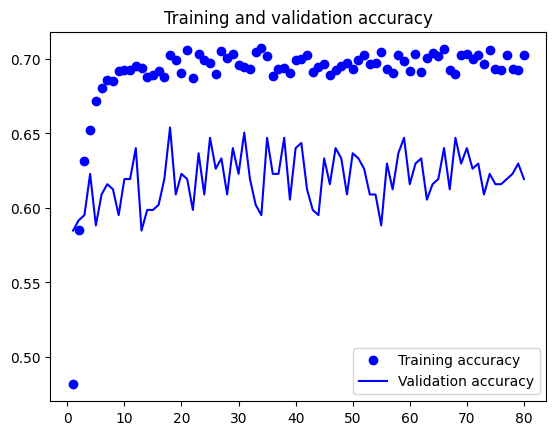

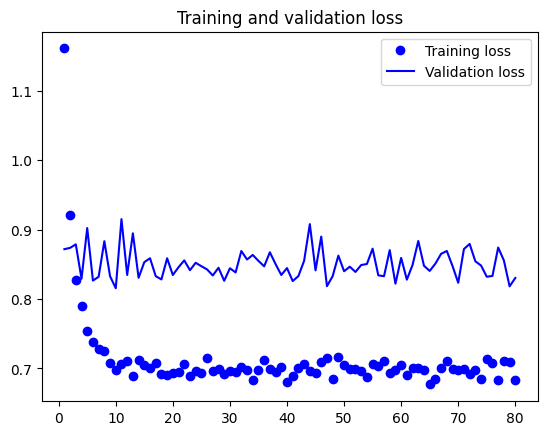

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

##### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 57%, loss 0.87)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_damagetype_mobilev2_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-16-51375a3e5599>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4668 - loss: 1.1295 - val_accuracy: 0.5882 - val_loss: 0.9351
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5649 - loss: 0.9372 - val_accuracy: 0.5433 - val_loss: 0.9522
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6021 - loss: 0.8880 - val_accuracy: 0.6125 - val_loss: 0.8632
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5997 - loss: 0.8733 - val_accuracy: 0.6332 - val_loss: 0.8562
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6514 - loss: 0.8098 - val_accuracy: 0.6401 - val_loss: 0.8693
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6290 - loss: 0.8317 - val_accuracy: 0.5952 - val_loss: 0.8961
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6363 - loss: 0.8077 - val_accuracy: 0.6471 - val_loss: 0.8617
Epoch 8/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms

In [ ]:
best_model = keras.models.load_model('yolo_v4_damagetype_mobilev2_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5547 - loss: 0.9092
test_loss: 0.904632031917572
test_acc: 0.5481481552124023


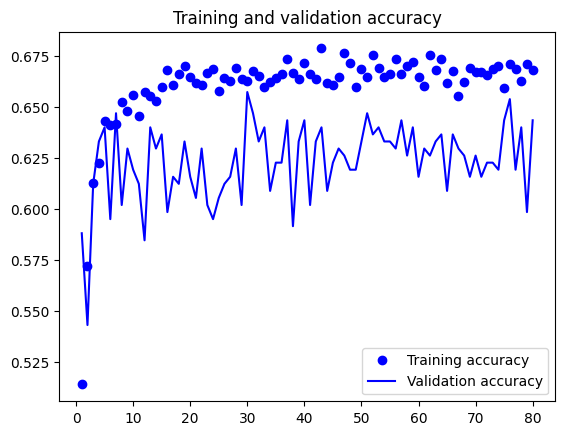

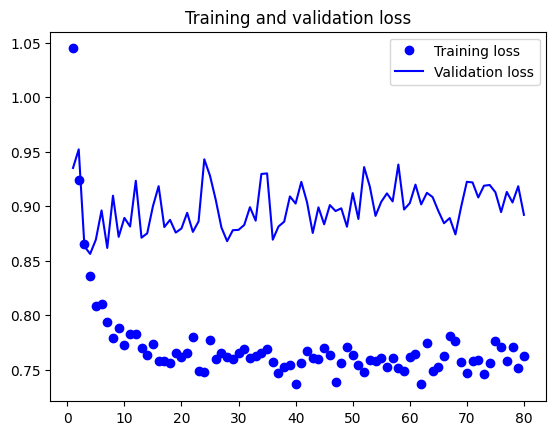

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3 Large

##### Data PreProcessing for MobileNet v3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 63.7%, loss 0.87)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'softmax')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 3)

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_damagetype_mobilev3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.4653 - loss: 1.2004 - val_accuracy: 0.6401 - val_loss: 0.8557
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5970 - loss: 0.9230 - val_accuracy: 0.6055 - val_loss: 0.8586
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6397 - loss: 0.8466 - val_accuracy: 0.6125 - val_loss: 0.8613
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6392 - loss: 0.8224 - val_accuracy: 0.6194 - val_loss: 0.8924
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6555 - loss: 0.7998 - val_accuracy: 0.6194 - val_loss: 0.8583
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6689 - loss: 0.7746 - val_accuracy: 0.6090 - val_loss: 0.8668
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6572 - loss: 0.7675 - val_accuracy: 0.5952 - val_loss: 0.8710
Epoch 8/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29

In [ ]:
best_model = keras.models.load_model('yolo_v4_damagetype_mobilev3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6360 - loss: 0.9068
test_loss: 0.9000016450881958
test_acc: 0.6370370388031006


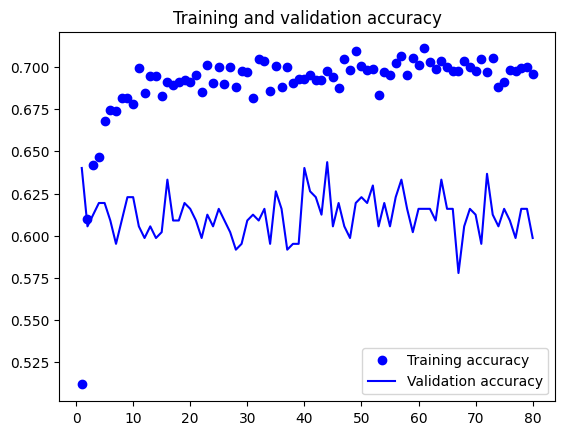

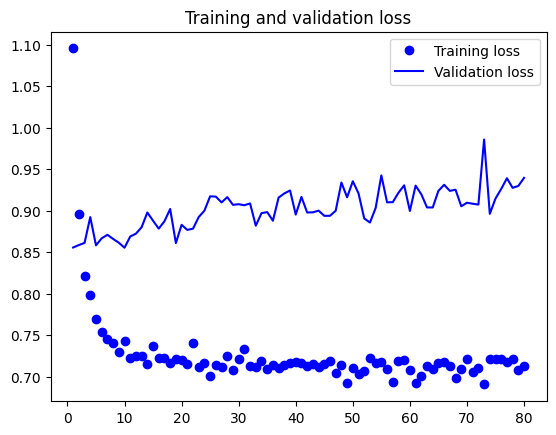

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Only Additional Data


## Original Data Download

* 클래스는 CombinationBreak 와 Others(StarBreak + PartialBullsEye + Stonechip)으로 분류하였습니다.
* 이유는, 이전 3가지 분류에서 Others로 묶은 클래스들이기도하고 묶은 3가지 클래스의 데이터 수가 많이 부족했기 때문입니다.
* jupyter notebook에서 증강 작업을 수행했고, 로컬에 저장해서 drive에 올렸습니다.
* 증강은 RandomRotation 40도, 수직,수평 20% 이내에서 이동, RandomZoom 20%, RandomFlip('horizontal')
* 각 데이터셋을 Roboflow에서 다시 라벨링하였고,그걸로 욜로 v2, v4 학습시켜 데이터셋 재구축했습니다. yolo v2는 전체 데이터의 5%를 미검출했고, v4는 모두 검출했습니다.

In [ ]:
file_id = '1gvC0_iiWedJ7fzD4_jk_H1ydi2uO1Ai8'
output = 'original_additioanl_data.zip'

if not os.path.isdir('original_additioanl_data'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('original_additioanl_data')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From (original): https://drive.google.com/uc?id=1gvC0_iiWedJ7fzD4_jk_H1ydi2uO1Ai8
From (redirected): https://drive.google.com/uc?id=1gvC0_iiWedJ7fzD4_jk_H1ydi2uO1Ai8&confirm=t&uuid=0544a201-ad33-43bc-b509-22016403cde6
To: /content/original_additioanl_data.zip
100%|██████████| 102M/102M [00:03<00:00, 31.6MB/s] 


'original_additioanl_data.zip' 파일이 정상적으로 다운로드되었습니다.
'original_additioanl_data.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data
* 불균형이 어느정도 완화된 결과를 볼 수 있음. -> 이 데이터로 학습

In [ ]:
train_combi_path = "./original_additioanl_data/train/CombinationBreak"
train_others_path = "./original_additioanl_data/train/Others"
test_combi_path = "./original_additioanl_data/test/CombinationBreak"
test_others_path = "./original_additioanl_data/test/Others"
validation_combi_path = "./original_additioanl_data/valid/CombinationBreak"
validation_others_path = "./original_additioanl_data/valid/Others"

# Call the function
count_image_files_in_directory(train_combi_path)
count_image_files_in_directory(train_others_path)
print('\n')
count_image_files_in_directory(test_combi_path)
count_image_files_in_directory(test_others_path)
print('\n')
count_image_files_in_directory(validation_combi_path)
count_image_files_in_directory(validation_others_path)

The number of image files in the directory 'train/CombinationBreak' is: 40
The number of image files in the directory 'train/Others' is: 36


The number of image files in the directory 'test/CombinationBreak' is: 9
The number of image files in the directory 'test/Others' is: 3


The number of image files in the directory 'valid/CombinationBreak' is: 9
The number of image files in the directory 'valid/Others' is: 3


### Create Dataset

In [ ]:
base_dir = pathlib.Path("./original_additioanl_data")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

Found 76 files belonging to 2 classes.
Found 12 files belonging to 2 classes.
Found 12 files belonging to 2 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'repair', 1: 'replace'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 75%, loss 0.58)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_additional_data_mobile_v1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-13-0bfc9e7596c4>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - accuracy: 0.5051 - loss: 0.8731 - val_accuracy: 0.2500 - val_loss: 0.9289
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.4737 - loss: 0.9189 - val_accuracy: 0.2500 - val_loss: 0.8071
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.4229 - loss: 0.8450 - val_accuracy: 0.2500 - val_loss: 0.8100
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.4044 - loss: 1.0239 - val_accuracy: 0.7500 - val_loss: 0.6068
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.4476 - loss: 0.8994 - val_accuracy: 0.7500 - val_loss: 0.5989
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4122 - loss: 0.9138 - val_accuracy: 0.7500 - val_loss: 0.6074
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4895 - loss: 0.8281 - val_accuracy: 0.5000 - val_loss: 0.6864
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.566

In [ ]:
best_model = keras.models.load_model('original_additional_data_mobile_v1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.5869
test_loss: 0.5868671536445618
test_acc: 0.75


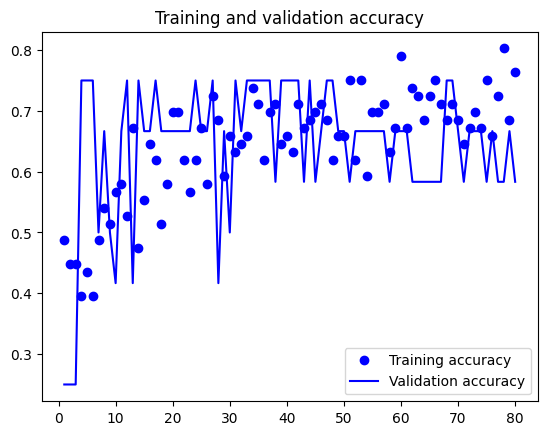

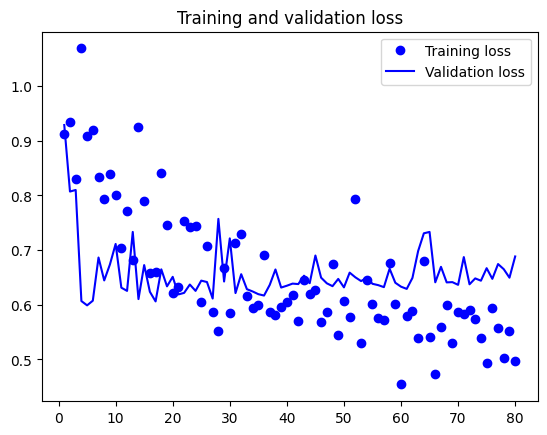

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 83.33%, loss 0.61)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_additional_data_mobile_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-17-6f77f1267677>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 957ms/step - accuracy: 0.5327 - loss: 0.8333 - val_accuracy: 0.7500 - val_loss: 0.6376
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.5368 - loss: 0.7638 - val_accuracy: 0.3333 - val_loss: 0.7532
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.5066 - loss: 0.8004 - val_accuracy: 0.6667 - val_loss: 0.6904
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6517 - loss: 0.6465 - val_accuracy: 0.4167 - val_loss: 0.7528
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5000 - loss: 0.7473 - val_accuracy: 0.6667 - val_loss: 0.6924
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5783 - loss: 0.7516 - val_accuracy: 0.6667 - val_loss: 0.6872
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.5929 - loss: 0.6637 - val_accuracy: 0.6667 - val_loss: 0.6878
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6439 

In [ ]:
best_model = keras.models.load_model('original_additional_data_mobile_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8333 - loss: 0.6113
test_loss: 0.6113365888595581
test_acc: 0.8333333134651184


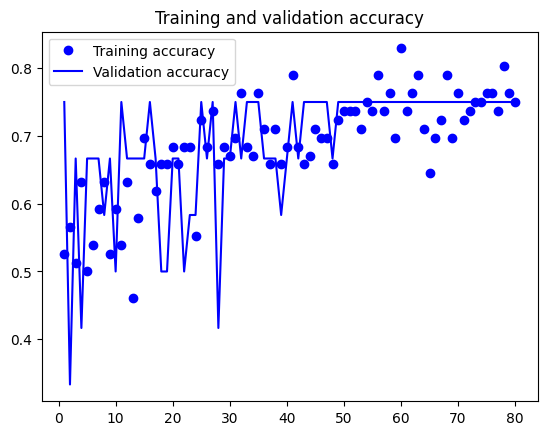

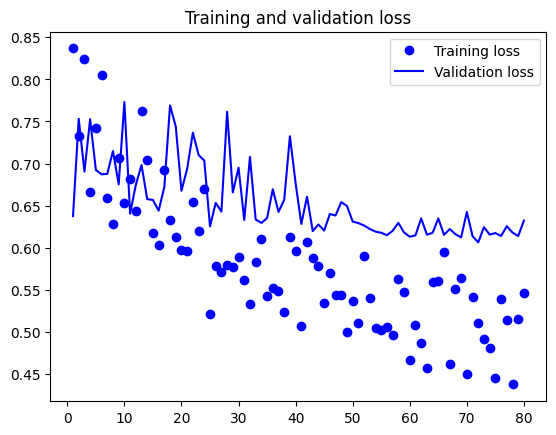

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3

#### Data PreProcessing for MobileNet v3

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 75%, loss 0.62)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="original_additional_data_mobile_v3_large_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5171 - loss: 0.8968 - val_accuracy: 0.7500 - val_loss: 0.6564
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.5578 - loss: 0.7914 - val_accuracy: 0.2500 - val_loss: 0.8473
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.3902 - loss: 0.8617 - val_accuracy: 0.7500 - val_loss: 0.6548
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.4961 - loss: 0.8895 - val_accuracy: 0.6667 - val_loss: 0.7024
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.6153 - loss: 0.7915 - val_accuracy: 0.5833 - val_loss: 0.7045
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5771 - loss: 0.7053 - val_accuracy: 0.4167 - val_loss: 0.7299
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.5471 - loss: 0.7954 - val_accuracy: 0.7500 - val_loss: 0.5835
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6414 -

In [ ]:
best_model = keras.models.load_model("original_additional_data_mobile_v3_large_augmentation_transfer.keras")
test_loss, test_acc = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.6248
test_loss: 0.624837338924408
test_acc: 0.75


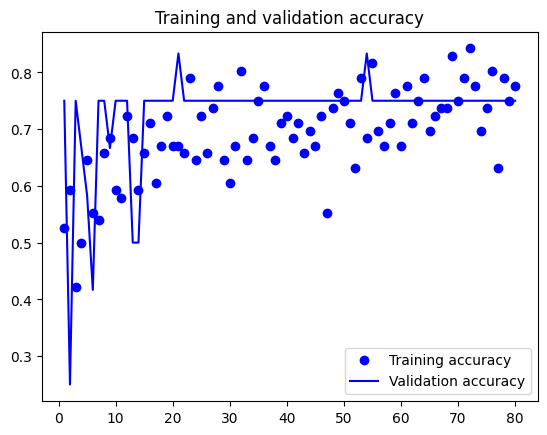

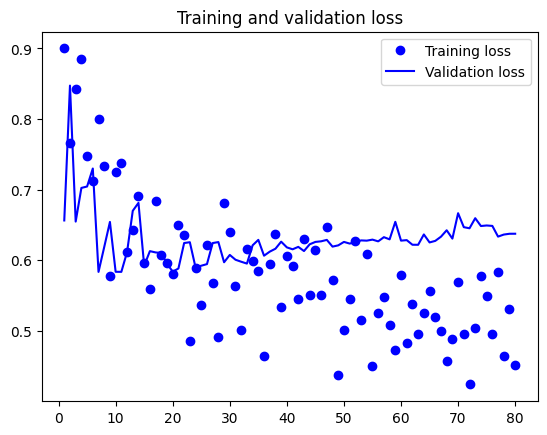

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## YOLO v2 Data Download
* YOLO v2 모델이 예측한 부분만을 crop하여 저장하였고, 데이터 증강을 통해 클래스 불균형을 해결하였습니다.
* 모델이 예측하지 못한 데이터는 원본 사진을 저장하여 사용하였습니다.

In [ ]:
file_id = '1UWGK5uk3FSYSm5nGl_9digTVd66hFt1Q'
output = 'yolo_v2_additional_data.zip'

if not os.path.isdir('yolo_v2_additional_data'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('yolo_v2_additional_data')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

Downloading...
From: https://drive.google.com/uc?id=1UWGK5uk3FSYSm5nGl_9digTVd66hFt1Q
To: /content/yolo_v2_additional_data.zip
100%|██████████| 640k/640k [00:00<00:00, 7.23MB/s]

'yolo_v2_additional_data.zip' 파일이 정상적으로 다운로드되었습니다.
'yolo_v2_additional_data.zip' 파일이 정상적으로 압축 해제되었습니다.


### Num of Data

In [ ]:
train_combi_path = "./yolo_v2_additional_data/train/CombinationBreak"
train_others_path = "./yolo_v2_additional_data/train/Others"
test_combi_path = "./yolo_v2_additional_data/test/CombinationBreak"
test_others_path = "./yolo_v2_additional_data/test/Others"
validation_combi_path = "./yolo_v2_additional_data/valid/CombinationBreak"
validation_others_path = "./yolo_v2_additional_data/valid/Others"

# Call the function
count_image_files_in_directory(train_combi_path)
count_image_files_in_directory(train_others_path)
print('\n')
count_image_files_in_directory(test_combi_path)
count_image_files_in_directory(test_others_path)
print('\n')
count_image_files_in_directory(validation_combi_path)
count_image_files_in_directory(validation_others_path)

The number of image files in the directory 'train/CombinationBreak' is: 129
The number of image files in the directory 'train/Others' is: 129


The number of image files in the directory 'test/CombinationBreak' is: 8
The number of image files in the directory 'test/Others' is: 3


The number of image files in the directory 'valid/CombinationBreak' is: 7
The number of image files in the directory 'valid/Others' is: 5


### Create Dataset

In [ ]:
base_dir = pathlib.Path("./yolo_v2_additional_data")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

Found 258 files belonging to 2 classes.
Found 12 files belonging to 2 classes.
Found 11 files belonging to 2 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'repair', 1: 'replace'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 81.81%, loss 0.49)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_additional_data_mobilev1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-30-0ac8b73cca14>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.5081 - loss: 0.7717 - val_accuracy: 0.5833 - val_loss: 0.6612
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5530 - loss: 0.7835 - val_accuracy: 0.6667 - val_loss: 0.6174
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6513 - loss: 0.6244 - val_accuracy: 0.6667 - val_loss: 0.6273
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6435 - loss: 0.6231 - val_accuracy: 0.6667 - val_loss: 0.6368
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7742 - loss: 0.5405 - val_accuracy: 0.5833 - val_loss: 0.6405
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7720 - loss: 0.4847 - val_accuracy: 0.6667 - val_loss: 0.6414
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7946 - loss: 0.4623 - val_accuracy: 0.5833 - val_loss: 0.6494
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7904 - loss: 0.4758 - val_accuracy: 0.5833 - val_loss: 0.6521

In [ ]:
best_model = keras.models.load_model('yolo_v2_additional_data_mobilev1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4940
test_loss: 0.49402114748954773
test_acc: 0.8181818127632141


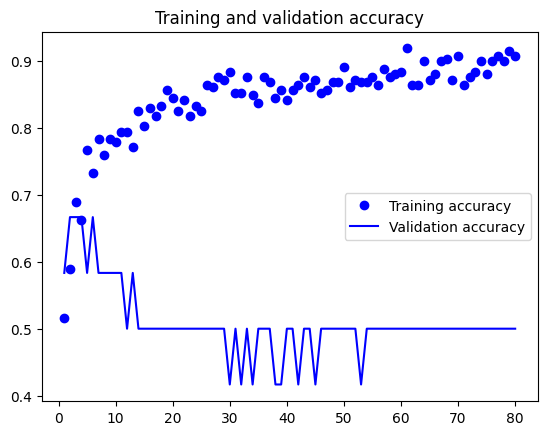

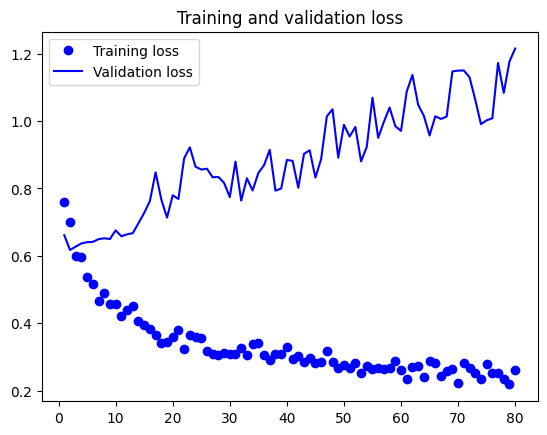

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 72.72%, loss 0.59)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_additional_data_mobilev2_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-34-43a895bb37f8>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.4988 - loss: 0.9259 - val_accuracy: 0.5833 - val_loss: 0.7197
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5781 - loss: 0.7680 - val_accuracy: 0.5833 - val_loss: 0.7098
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6491 - loss: 0.6564 - val_accuracy: 0.5000 - val_loss: 0.7152
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7401 - loss: 0.5468 - val_accuracy: 0.5833 - val_loss: 0.8339
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7379 - loss: 0.5561 - val_accuracy: 0.5000 - val_loss: 0.7578
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7532 - loss: 0.4837 - val_accuracy: 0.5000 - val_loss: 0.8095
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7426 - loss: 0.5003 - val_accuracy: 0.5000 - val_loss: 0.8535
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7775 - loss: 0.4571 - val_accuracy: 0.4167 - val_loss: 0.8528

In [ ]:
best_model = keras.models.load_model('yolo_v2_additional_data_mobilev2_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5900
test_loss: 0.5900367498397827
test_acc: 0.7272727489471436


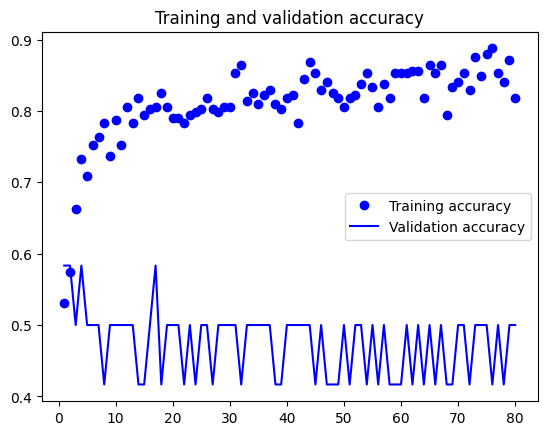

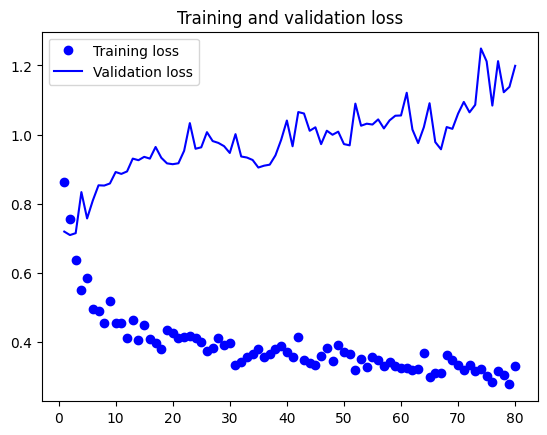

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3 Large

#### Data PreProcessing for MobileNet v3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 81.81%, loss 0.57)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v2_additional_data_mobilev3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.5540 - loss: 0.7183 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6328 - loss: 0.6384 - val_accuracy: 0.5000 - val_loss: 0.7270
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7108 - loss: 0.5491 - val_accuracy: 0.5000 - val_loss: 0.7670
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7240 - loss: 0.5400 - val_accuracy: 0.5000 - val_loss: 0.8254
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7706 - loss: 0.4916 - val_accuracy: 0.4167 - val_loss: 0.8448
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8106 - loss: 0.4556 - val_accuracy: 0.5000 - val_loss: 0.8229
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8133 - loss: 0.4251 - val_accuracy: 0.4167 - val_loss: 0.8788
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8322 - loss: 0.3870 - val_accuracy: 0.5000 - val_loss: 0.8375

In [ ]:
best_model = keras.models.load_model('yolo_v2_additional_data_mobilev3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5774
test_loss: 0.5774089097976685
test_acc: 0.8181818127632141


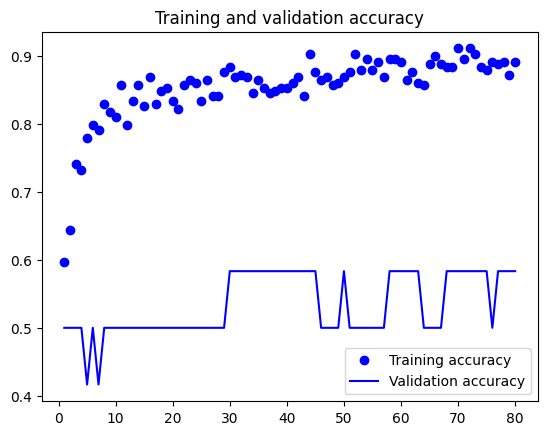

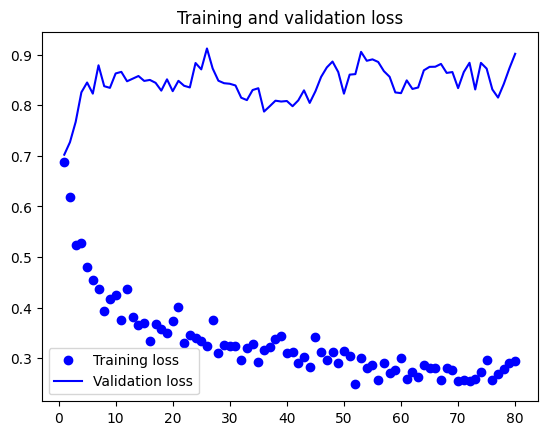

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Yolo v4 Data Download

In [ ]:
file_id = '1SMvqd56rGAmtqpk9qRwOJuPmbmZrpXqy'
output = 'yolo_v4_additional_data.zip'

if not os.path.isdir('yolo_v4_additional_data'):
    gdown.download(id=file_id, output=output, quiet=False)

    # 파일이 정상적으로 다운로드되었는지 확인
    if os.path.isfile(output):
        print(f"'{output}' 파일이 정상적으로 다운로드되었습니다.")
    else:
        print(f"'{output}' 파일 다운로드에 실패했습니다.")

    # ZIP 파일인지 확인
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('yolo_v4_additional_data')
            print(f"'{output}' 파일이 정상적으로 압축 해제되었습니다.")
    except zipfile.BadZipFile:
        print(f"'{output}' 파일이 ZIP 파일이 아니거나 손상되었습니다.")

### Num of Data

In [ ]:
train_combi_path = "./yolo_v4_additional_data/train/CombinationBreak"
train_others_path = "./yolo_v4_additional_data/train/Others"
test_combi_path = "./yolo_v4_additional_data/test/CombinationBreak"
test_others_path = "./yolo_v4_additional_data/test/Others"
validation_combi_path = "./yolo_v4_additional_data/valid/CombinationBreak"
validation_others_path = "./yolo_v4_additional_data/valid/Others"

# Call the function
count_image_files_in_directory(train_combi_path)
count_image_files_in_directory(train_others_path)
print('\n')
count_image_files_in_directory(test_combi_path)
count_image_files_in_directory(test_others_path)
print('\n')
count_image_files_in_directory(validation_combi_path)
count_image_files_in_directory(validation_others_path)

The number of image files in the directory 'train/CombinationBreak' is: 133
The number of image files in the directory 'train/Others' is: 124


The number of image files in the directory 'test/CombinationBreak' is: 8
The number of image files in the directory 'test/Others' is: 3


The number of image files in the directory 'valid/CombinationBreak' is: 7
The number of image files in the directory 'valid/Others' is: 5


### Create Dataset

In [ ]:
base_dir = pathlib.Path("./yolo_v4_additional_data")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir / "train",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(360, 360),
    batch_size=32,
    class_names=['CombinationBreak', 'Others']
    )

Found 257 files belonging to 2 classes.
Found 12 files belonging to 2 classes.
Found 11 files belonging to 2 classes.


In [ ]:
# iterator = iter(train_dataset)
# batch_1 = next(iterator)

In [ ]:
# label_dict = {0: 'repair', 1: 'replace'}

# plt.figure(figsize=(15,30))
# for i in range(32):
#     plt.subplot(8,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     label = batch_1[1][i].numpy()
#     plt.imshow(batch_1[0][i]/255)
#     plt.xlabel(label_dict[label])
# plt.show()

### MobileNet v1

#### Data PreProcessing for MobileNet v1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 72.72%, loss 0.58)

In [ ]:
def build_model(input_shape, num_out):
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)
  conv_base.trainable = False

  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_additional_data_mobilev1_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-49-bc89b418f19b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNet(include_top = False, input_shape = input_shape)


Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.5901 - loss: 0.6971 - val_accuracy: 0.5833 - val_loss: 0.7212
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6691 - loss: 0.6230 - val_accuracy: 0.5833 - val_loss: 0.7428
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6879 - loss: 0.5847 - val_accuracy: 0.5833 - val_loss: 0.6658
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7773 - loss: 0.5047 - val_accuracy: 0.5833 - val_loss: 0.7736
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7748 - loss: 0.4830 - val_accuracy: 0.5833 - val_loss: 0.7537
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7740 - loss: 0.4631 - val_accuracy: 0.5833 - val_loss: 0.7577
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7920 - loss: 0.4492 - val_accuracy: 0.5833 - val_loss: 0.7552
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7934 - loss: 0.4594 - val_accuracy: 0.5000 - val_loss: 0.7174

In [ ]:
best_model = keras.models.load_model('yolo_v4_additional_data_mobilev1_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5831
test_loss: 0.5831161737442017
test_acc: 0.7272727489471436


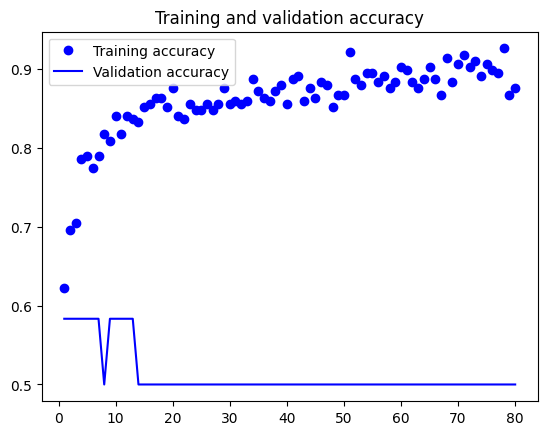

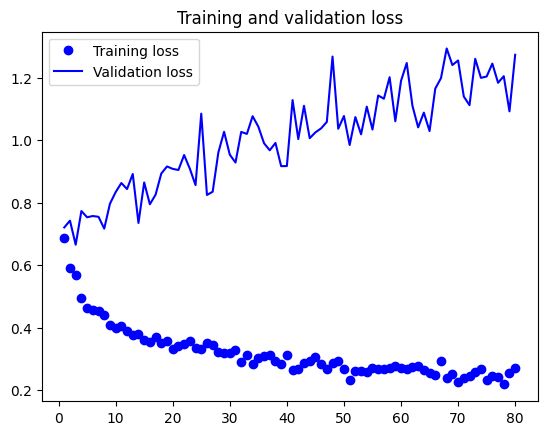

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v2

#### Data PreProcessing for MobileNet v2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_preprocess(images)
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 81.81%, loss 0.53)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_additional_data_mobilev2_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

<ipython-input-53-282f9cfc1dd2>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (360,360,3))


Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.5212 - loss: 0.7686 - val_accuracy: 0.6667 - val_loss: 0.6084
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6497 - loss: 0.6305 - val_accuracy: 0.5833 - val_loss: 0.6731
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6486 - loss: 0.6475 - val_accuracy: 0.5833 - val_loss: 0.6060
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6860 - loss: 0.6048 - val_accuracy: 0.6667 - val_loss: 0.6946
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6559 - loss: 0.6304 - val_accuracy: 0.5833 - val_loss: 0.8092
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7321 - loss: 0.5674 - val_accuracy: 0.6667 - val_loss: 0.7676
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7550 - loss: 0.5243 - val_accuracy: 0.6667 - val_loss: 0.6342
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7446 - loss: 0.5074 - val_accuracy: 0.6667 - val_loss: 0.6442

In [ ]:
best_model = keras.models.load_model('yolo_v4_additional_data_mobilev2_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5392
test_loss: 0.5391818284988403
test_acc: 0.8181818127632141


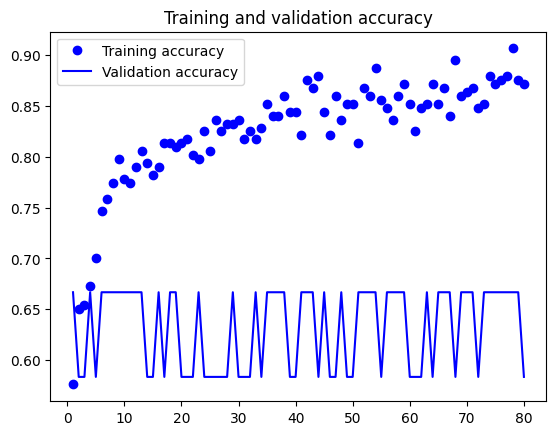

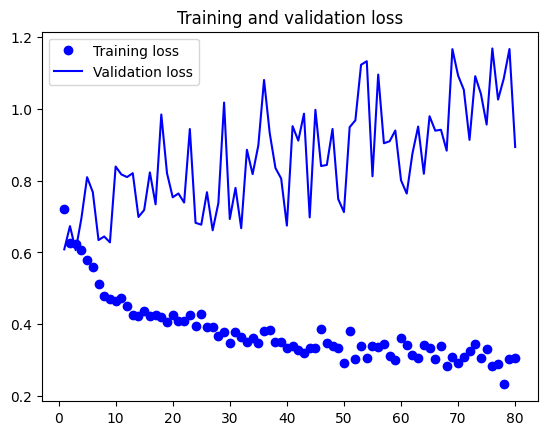

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### MobileNet v3 Large

#### Data PreProcessing for MobileNet v3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

# 전처리 함수 정의
def preprocess_images(images, labels):
    images = mobilenet_v3_preprocess(images)  # MobileNetV3 전용 전처리 함수 사용
    return images, labels

# 전처리 함수 적용
mobile_train_dataset = train_dataset.map(preprocess_images)
mobile_validation_dataset = validation_dataset.map(preprocess_images)
mobile_test_dataset = test_dataset.map(preprocess_images)

#### Transfer Learning (Score: acc 72.72%, loss 0.52)

In [ ]:
def build_model(input_shape, num_out):
  inputs = keras.Input(shape = input_shape)
  x = data_augmenation(inputs)
  x = conv_base(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  outputs = Dense(num_out, activation = 'sigmoid')(x)
  return keras.Model(inputs = inputs, outputs = outputs)

data_augmenation = keras.Sequential([RandomTranslation(0.2,0.2,fill_mode='nearest'), RandomZoom(0.2)])

conv_base = MobileNetV3Large(include_top = False, input_shape = (360,360,3))
conv_base.trainable = False

model = build_model((360,360,3), 1)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
      filepath="yolo_v4_additional_data_mobilev3_augmentation_transfer.keras",
      save_best_only=True,
      monitor="val_loss")]

history = model.fit(
    mobile_train_dataset,
    epochs=80,
    validation_data=mobile_validation_dataset,
    callbacks=callbacks)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.5478 - loss: 0.7637 - val_accuracy: 0.5000 - val_loss: 0.7100
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6208 - loss: 0.6317 - val_accuracy: 0.5833 - val_loss: 0.7084
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7401 - loss: 0.5574 - val_accuracy: 0.5833 - val_loss: 0.7179
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6817 - loss: 0.5856 - val_accuracy: 0.5833 - val_loss: 0.7255
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7031 - loss: 0.5521 - val_accuracy: 0.5833 - val_loss: 0.7359
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7804 - loss: 0.4842 - val_accuracy: 0.5833 - val_loss: 0.7696
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7867 - loss: 0.4501 - val_accuracy: 0.5833 - val_loss: 0.7369
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8185 - loss: 0.4183 - val_accuracy: 0.5833 - val_loss: 0.8067

In [ ]:
best_model = keras.models.load_model('yolo_v4_additional_data_mobilev3_augmentation_transfer.keras')
(test_loss, test_acc) = best_model.evaluate(mobile_test_dataset)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5279
test_loss: 0.5278788208961487
test_acc: 0.7272727489471436


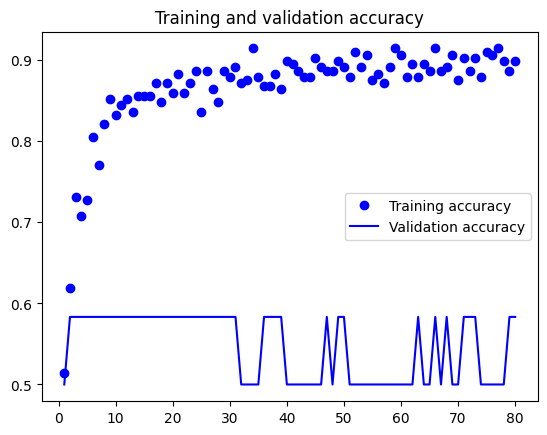

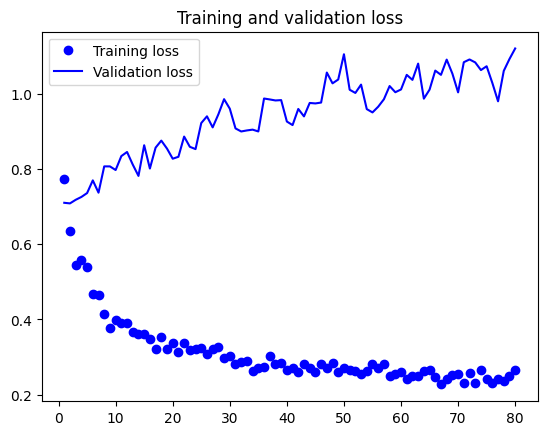

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()